In [1]:
import torch
import os
import pickle
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import pandas as pd
from matplotlib.ticker import FormatStrFormatter

In [2]:
from matplotlib import font_manager

font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
font_prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['axes.unicode_minus'] = False

In [3]:
lead = 1
dir_sub = 'deep_integration_lead' + str(lead)
dir_sub_patent = 'deep_integration_lead_patent' + str(lead)
filepath_config = os.path.join(r'../result/config', 'deep_integration_' + str(lead) + '.pkl')
with open(filepath_config, 'rb') as f:
    config = pickle.load(f)
filepath_checkpoint = r'../result/checkpoint/deep_integration_'+ str(lead) + '.pth'

In [4]:
config.keys()

dict_keys(['model', 'dataset', 'train', 'log'])

In [5]:
config['dataset'].keys()

dict_keys(['lead', 'time_axis', 'dir_dataset', 'filepath_statistics', 'lst_variable_feature', 'lst_is_mask_feature', 'lst_level_feature', 'lst_variable_label', 'lst_is_mask_label', 'lst_level_label', 'dim_level_cat', 'break_percent', 'batch_size', 'shuffle', 'drop_last', 'num_workers'])

In [6]:
# # load model
from package.SimVP_Simpler_yet_Better_Video_Prediction_master.model import SimVP
from collections import OrderedDict

device_ids = [1]
gpu_num = len(device_ids)

shape_in_ = config['model']['shape_in']
seq_len_, channel_in_, H_, W_ = shape_in_
channel_out_ = config['model']['channel_out']
hid_S_ = config['model']['hid_S']
hid_T_ = config['model']['hid_T']
N_S_ = config['model']['N_S']
N_T_ = config['model']['N_T']
groups_ = config['model']['groups']

model = SimVP(shape_in=shape_in_, channel_out=channel_out_,
               hid_S=hid_S_, hid_T=hid_T_, N_S=N_S_, N_T=N_T_,
               groups=groups_)
model = model.cuda(device=device_ids[0])

checkpoint = torch.load(filepath_checkpoint, weights_only=False, map_location='cuda:' + str(device_ids[0]))
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [7]:
# # build dataset
from package.utils.MyDataset import Dataset
from torch.utils.data import Subset, DataLoader

def transform_x(x):
    x = np.ascontiguousarray(x)
    return x

def transform_y(y):
    y = np.ascontiguousarray(y)
    return y

time_axis = np.load('../data/info_axis/time.npy')
dir_dataset = r'../data/dataset'
filepath_statistics = r'../data/statistics/all/statistics.pkl'

lst_variable_feature = config['dataset']['lst_variable_feature']
lst_is_mask_feature = config['dataset']['lst_is_mask_feature']
lst_level_feature = config['dataset']['lst_level_feature']

lst_variable_label = config['dataset']['lst_variable_label']
lst_is_mask_label = config['dataset']['lst_is_mask_label']
lst_level_label = config['dataset']['lst_level_label']

dim_level_cat = config['dataset']['dim_level_cat']
dataset = Dataset(lead,
                  time_axis, dir_dataset, filepath_statistics,
                  lst_variable_feature, lst_is_mask_feature, lst_level_feature,
                  lst_variable_label, lst_is_mask_label, lst_level_label,
                  dim_level_cat,
                  transform_x, transform_y)

indices = list(range(len(dataset)))
break_point = int(len(dataset) * config['dataset']['break_percent'])
indices_test = indices[break_point:]
dataset_test = Subset(dataset, indices_test)
dataloader_test = DataLoader(dataset_test, batch_size=5,
                             shuffle=False, drop_last=False, num_workers=gpu_num)

SimVP(
  (enc): Encoder(
    (enc): Sequential(
      (0): ConvSC(
        (conv): BasicConv2d(
          (conv): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(2, 16, eps=1e-05, affine=True)
          (act): LeakyReLU(negative_slope=0.2, inplace=True)
        )
      )
      (1): ConvSC(
        (conv): BasicConv2d(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (norm): GroupNorm(2, 16, eps=1e-05, affine=True)
          (act): LeakyReLU(negative_slope=0.2, inplace=True)
        )
      )
      (2): ConvSC(
        (conv): BasicConv2d(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(2, 16, eps=1e-05, affine=True)
          (act): LeakyReLU(negative_slope=0.2, inplace=True)
        )
      )
      (3): ConvSC(
        (conv): BasicConv2d(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (

In [8]:
dataset_test[0][0].shape

In [9]:
len(dataset_test)

(39, 4, 224, 224)

In [10]:
model.eval()
with torch.no_grad():
    for i, (feature_test, label_test) in enumerate(dataloader_test):
        feature_test = feature_test.cuda(device=device_ids[0])
        label_test = label_test.cuda(device=device_ids[0])
        predict_test = model(feature_test)
        x = predict_test.to('cpu').detach().numpy()
        y = label_test.to('cpu').detach().numpy()
        print(x.shape, y.shape)
        if i == 0:
            x_merge = x
            y_merge = y
        else:
            x_merge = np.concatenate((x_merge, x), axis=0)
            y_merge = np.concatenate((y_merge, y), axis=0)
print(x_merge.shape, y_merge.shape)

512

In [11]:
# mask
mask_all = np.all(y_merge == 0, axis=0)

(5, 39, 4, 224, 224) (5, 39, 4, 224, 224)
(5, 39, 4, 224, 224) (5, 39, 4, 224, 224)
(5, 39, 4, 224, 224) (5, 39, 4, 224, 224)
(5, 39, 4, 224, 224) (5, 39, 4, 224, 224)
(5, 39, 4, 224, 224) (5, 39, 4, 224, 224)
(5, 39, 4, 224, 224) (5, 39, 4, 224, 224)
(5, 39, 4, 224, 224) (5, 39, 4, 224, 224)
(5, 39, 4, 224, 224) (5, 39, 4, 224, 224)
(5, 39, 4, 224, 224) (5, 39, 4, 224, 224)
(5, 39, 4, 224, 224) (5, 39, 4, 224, 224)
(5, 39, 4, 224, 224) (5, 39, 4, 224, 224)
(5, 39, 4, 224, 224) (5, 39, 4, 224, 224)
(5, 39, 4, 224, 224) (5, 39, 4, 224, 224)
(5, 39, 4, 224, 224) (5, 39, 4, 224, 224)
(5, 39, 4, 224, 224) (5, 39, 4, 224, 224)
(5, 39, 4, 224, 224) (5, 39, 4, 224, 224)
(5, 39, 4, 224, 224) (5, 39, 4, 224, 224)
(5, 39, 4, 224, 224) (5, 39, 4, 224, 224)
(5, 39, 4, 224, 224) (5, 39, 4, 224, 224)
(5, 39, 4, 224, 224) (5, 39, 4, 224, 224)
(5, 39, 4, 224, 224) (5, 39, 4, 224, 224)
(5, 39, 4, 224, 224) (5, 39, 4, 224, 224)
(5, 39, 4, 224, 224) (5, 39, 4, 224, 224)
(5, 39, 4, 224, 224) (5, 39, 4, 22

In [12]:
lon = np.load('../data/info_axis/lon_img.npy')
lat = np.load('../data/info_axis/lat_img.npy')
depth = np.load('../data/info_axis/depth_img.npy')
time_axis = np.load('../data/info_axis/time.npy')[lead:][break_point:]
variable_lst = ['u', 'v', 't', 's']
title_lst = ['UO', 'VO', 'Temperature', 'Salinity']
title_cn_lst = ['纬向海水流速', '经向海水流速', '海水温度', '海水盐度', ]
unit_lst = ['m/s', 'm/s', '℃', 'PSU']

In [13]:
# RMSE
rmse = np.sqrt(np.nanmean((x_merge - y_merge) ** 2, axis=0))
rmse[mask_all] = np.nan

In [14]:
# PCC
pcc = np.full_like(rmse, fill_value=np.nan)
for d in range(depth.size):
    for v in range(len(variable_lst)):
        for lat_n in range(lat.size):
            for lon_n in range(lon.size):
                if ~mask_all[d, v, lat_n, lon_n]:
                    x_temp = x_merge[:, d, v, lat_n, lon_n]
                    y_temp = y_merge[:, d, v, lat_n, lon_n]
                    pcc_temp = np.corrcoef(x_temp, y_temp)[0, 1]
                    # update
                    pcc[d, v, lat_n, lon_n] = pcc_temp

# Draw

In [16]:
# point target
lon_p1, lat_p1 = 108, 20
lon_p2, lat_p2 = 111.5, 19.5

idx_lon1, idx_lat1 = np.argmin(np.abs(lon - lon_p1)), np.argmin(np.abs(lat - lat_p1))
idx_lon2, idx_lat2 = np.argmin(np.abs(lon - lon_p2)), np.argmin(np.abs(lat - lat_p2))
print(idx_lon1, idx_lat1)

96 144


In [16]:
def get_color_range_max(arr, mask, range_target=(0.9, 0.95)):
    size_all = arr[~mask].size
    value_min = np.nanmin(arr)
    value_max = np.nanmax(arr)

    ratio_target = 0
    value_left = value_min
    value_right = value_max
    value_target = (value_left + value_right) / 2
    while ratio_target < range_target[0] or ratio_target > range_target[1]:
        # print(value_target)
        ratio_target = arr[arr <= value_target].size / size_all
        if ratio_target < range_target[0]:
            value_left = value_target
        else:
            value_right = value_target
        value_target = (value_left + value_right) / 2
    return value_target, ratio_target


def get_color_range_min(arr, mask, range_target=(0.9, 0.95)):
    size_all = arr[~mask].size
    value_min = np.nanmin(arr)
    value_max = np.nanmax(arr)

    ratio_target = 0
    value_left = value_min
    value_right = value_max
    value_target = (value_left + value_right) / 2
    while ratio_target < range_target[0] or ratio_target > range_target[1]:
        # print(value_target)
        ratio_target = arr[arr >= value_target].size / size_all
        if ratio_target < range_target[0]:
            value_right = value_target
        else:
            value_left = value_target
        value_target = (value_left + value_right) / 2
    return value_target, ratio_target

96 144


# Draw of report

In [18]:
# variable_s_lst = ['u', 'u', 'v', 'v', 't', 't', 's', 's', ]
# depth_s_lst = [0, 50, 0, 50, 0, 50, 0, 50, ]
#
# # variable_s_lst = ['u']
# # depth_s_lst = [0]
#
# for i in range(len(variable_s_lst)):
#     variable_s = variable_s_lst[i]
#     depth_s = depth_s_lst[i]
#
#     idx_depth = np.argmin(np.abs(depth - depth_s))
#     idx_variable = variable_lst.index(variable_s)
#
#     depth_str = str(round(depth[idx_depth], 2))
#     print(idx_depth, idx_variable)
#
#     lon_axis_temp = lon
#     lat_axis_temp = lat
#     time_axis_temp = time_axis.astype('int64') / 10**9
#
#     rmse_temp = rmse[idx_depth, idx_variable, :]
#     pcc_temp = pcc[idx_depth, idx_variable, :]
#     # mask rmse
#     mask_temp = mask_all[idx_depth, idx_variable, :]
#     rmse_temp[mask_temp] = np.nan
#
#     # get color range
#     rmse_min_color, ratio_rmse_min = get_color_range_min(rmse_temp, mask_temp)
#     rmse_max_color, ratio_rmse_max = get_color_range_max(rmse_temp, mask_temp)
#
#     pcc_min_color, ratio_pcc_min = get_color_range_min(pcc_temp, mask_temp)
#     pcc_max_color, ratio_pcc_max = get_color_range_max(pcc_temp, mask_temp)
#
#     print('rmse_min', rmse_min_color, ratio_rmse_min)
#     print('rmse_max', rmse_max_color, ratio_rmse_max)
#     print('pcc_min', pcc_min_color, ratio_pcc_min)
#     print('pcc_max', pcc_max_color, ratio_pcc_max)
#
#     lon_point_temp1 = lon[idx_lon1]
#     lat_point_temp1 = lat[idx_lat1]
#
#     lon_point_temp2 = lon[idx_lon2]
#     lat_point_temp2 = lat[idx_lat2]
#
#     prediction_point_temp1 = x_merge[:, idx_depth, idx_variable, idx_lat1, idx_lon1]
#     label_point_temp1 = y_merge[:, idx_depth, idx_variable, idx_lat1, idx_lon1]
#
#     prediction_point_temp2 = x_merge[:, idx_depth, idx_variable, idx_lat2, idx_lon2]
#     label_point_temp2 = y_merge[:, idx_depth, idx_variable, idx_lat2, idx_lon2]
#
#     # 设置支持摄氏度符号的字体
#     plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Arial Unicode MS', 'SimHei']
#     plt.rcParams['axes.unicode_minus'] = False
#     fontsize = 16
#     s_size = 50
#     # 创建图形和子图
#     fig = plt.figure(figsize=(22, 10), facecolor='white')
#     # 主网格
#     gs = fig.add_gridspec(2, 2)
#
#     # ==========  (1, 1) ==========
#     ax1 = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
#
#     # 指定经纬度范围（示例范围，请根据您的数据调整）
#     lon_min, lon_max = lon.min(), lon.max()  # 经度范围
#     lat_min, lat_max = lat.min(), lat.max()    # 纬度范围
#
#     # 设置地图范围
#     ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
#
#     # 绘制数据
#     cf = ax1.pcolormesh(lon, lat, rmse_temp, cmap='jet', transform=ccrs.PlateCarree(),
#                         vmin=rmse_min_color, vmax=rmse_max_color)
#
#     # 添加地理特征
#     ax1.add_feature(cfeature.LAND, facecolor='lightgray', alpha=1, zorder=1)
#     ax1.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=1.2, alpha=1, zorder=2)
#
#     # 添加散点
#     ax1.scatter(lon_point_temp1, lat_point_temp1, s=s_size, color='magenta', marker='^',
#                transform=ccrs.PlateCarree(),
#                label='Station-1', zorder=5)
#     ax1.scatter(lon_point_temp2, lat_point_temp2, s=s_size, color='magenta', marker='o',
#                transform=ccrs.PlateCarree(),
#                label='Station-2', zorder=5)
#
#     # 设置标题和标签
#     ax1.set_title('RMSE Spatial Distribution' + '(' + title_lst[idx_variable] + '-' + depth_str + 'm)', fontsize=fontsize, pad=15, fontweight='bold')
#     ax1.set_xlabel('Longitude', fontsize=fontsize + 2)
#     ax1.set_ylabel('Latitude', fontsize=fontsize + 2)
#
#     # 设置经纬度刻度和格式（使用显示范围，而不是数据范围）
#     display_lon_min, display_lon_max = ax1.get_xlim()  # 获取实际显示范围
#     display_lat_min, display_lat_max = ax1.get_ylim()
#
#     lon_step = max(1, round((display_lon_max - display_lon_min)/4))  # 4个主刻度
#     lat_step = max(1, round((display_lat_max - display_lat_min)/4))
#
#     # 设置刻度
#     ax1.set_xticks(np.arange(display_lon_min, display_lon_max, lon_step),
#                   crs=ccrs.PlateCarree())
#     ax1.set_yticks(np.arange(display_lat_min, display_lat_max, lat_step),
#                   crs=ccrs.PlateCarree())
#
#     # 使用经纬度格式化器
#     lon_formatter = LongitudeFormatter(zero_direction_label=True)
#     lat_formatter = LatitudeFormatter()
#     ax1.xaxis.set_major_formatter(lon_formatter)
#     ax1.yaxis.set_major_formatter(lat_formatter)
#
#     # 调整刻度标签大小
#     ax1.tick_params(labelsize=fontsize)
#
#     # 添加网格线
#     ax1.gridlines(draw_labels=False, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
#
#     # 添加colorbar
#     cbar = plt.colorbar(cf, ax=ax1, pad=0.02, aspect=30)
#     cbar.set_label(title_lst[idx_variable] + ' RMSE (' + unit_lst[idx_variable] + ')', fontsize=fontsize)
#     cbar.ax.tick_params(labelsize=12)
#
#     ax1.legend(fontsize=fontsize, framealpha=0.8, loc='upper left')
#
#     # ========== (2, 1) ==========
#     ax3 = fig.add_subplot(gs[2], projection=ccrs.PlateCarree())
#
#     # 指定经纬度范围（示例范围，请根据您的数据调整）
#     lon_min, lon_max = lon.min(), lon.max()  # 经度范围
#     lat_min, lat_max = lat.min(), lat.max()    # 纬度范围
#
#     # 设置地图范围
#     ax3.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
#
#     # 绘制数据
#     cf = ax3.pcolormesh(lon, lat, pcc_temp, cmap='jet', transform=ccrs.PlateCarree(),
#                         vmin=0, vmax=1)
#
#     # 添加地理特征
#     ax3.add_feature(cfeature.LAND, facecolor='lightgray', alpha=1, zorder=1)
#     ax3.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=1.2, alpha=1, zorder=2)
#
#     # 添加散点
#     ax3.scatter(lon_point_temp1, lat_point_temp1, s=s_size, color='magenta', marker='^',
#                transform=ccrs.PlateCarree(),
#                label='Station-1', zorder=5)
#     ax3.scatter(lon_point_temp2, lat_point_temp2, s=s_size, color='magenta', marker='o',
#                transform=ccrs.PlateCarree(),
#                label='Station-2', zorder=5)
#
#     # 设置标题和标签
#     ax3.set_title('PCC Spatial Distribution' + '(' + title_lst[idx_variable] + '-' + depth_str + 'm)', fontsize=fontsize, pad=15, fontweight='bold')
#     ax3.set_xlabel('Longitude', fontsize=fontsize + 2)
#     ax3.set_ylabel('Latitude', fontsize=fontsize + 2)
#
#     # 设置经纬度刻度和格式（使用显示范围，而不是数据范围）
#     display_lon_min, display_lon_max = ax3.get_xlim()  # 获取实际显示范围
#     display_lat_min, display_lat_max = ax3.get_ylim()
#
#     lon_step = max(1, round((display_lon_max - display_lon_min)/4))  # 4个主刻度
#     lat_step = max(1, round((display_lat_max - display_lat_min)/4))
#
#     # 设置刻度
#     ax3.set_xticks(np.arange(display_lon_min, display_lon_max, lon_step),
#                   crs=ccrs.PlateCarree())
#     ax3.set_yticks(np.arange(display_lat_min, display_lat_max, lat_step),
#                   crs=ccrs.PlateCarree())
#
#     # 使用经纬度格式化器
#     lon_formatter = LongitudeFormatter(zero_direction_label=True)
#     lat_formatter = LatitudeFormatter()
#     ax3.xaxis.set_major_formatter(lon_formatter)
#     ax3.yaxis.set_major_formatter(lat_formatter)
#
#     # 调整刻度标签大小
#     ax3.tick_params(labelsize=fontsize)
#
#     # 添加网格线
#     ax3.gridlines(draw_labels=False, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
#
#     # 添加colorbar
#     cbar = plt.colorbar(cf, ax=ax3, pad=0.02, aspect=30)
#     cbar.set_label(title_lst[idx_variable] + ' PCC', fontsize=fontsize)
#     cbar.ax.tick_params(labelsize=12)
#
#     ax3.legend(fontsize=fontsize, framealpha=0.8, loc='upper left')
#
#     # ==========（1, 2）==========
#     ax2 = fig.add_subplot(gs[1])
#     ax2.plot(time_axis, label_point_temp1, label='Real',
#                      color='navy', linewidth=2)
#     ax2.plot(time_axis, prediction_point_temp1, label='Predicted',
#                      color='darkorange', linewidth=3, linestyle='--')
#
#     ax2.set_title(f'Station-1\n({lon_point_temp1:.2f}°E, {lat_point_temp1:.2f}°N)',
#                  fontsize=fontsize, pad=15, fontweight='bold')
#     ax2.set_xticklabels([])
#
#     # 设置时间序列图的刻度标签大小
#     ax2.tick_params(axis='both', which='major', labelsize=fontsize-4)
#
#     ax2.set_ylabel(title_lst[idx_variable] + ' (' + unit_lst[idx_variable] + ')', fontsize=fontsize)
#     ax2.grid(True, linestyle='--', alpha=0.6)
#     ax2.legend(fontsize=fontsize, framealpha=0.8)
#
#     # 2.2 第二个子图（可以添加其他内容，如误差分布）
#     ax4 = fig.add_subplot(gs[3])
#     ax4.plot(time_axis, label_point_temp2, label='Real',
#                      color='navy', linewidth=2)
#     ax4.plot(time_axis, prediction_point_temp2, label='Predicted',
#                      color='darkorange', linewidth=3, linestyle='--')
#
#     ax4.set_title(f'Station-2\n({lon_point_temp2:.2f}°E, {lat_point_temp2:.2f}°N)',
#                  fontsize=fontsize, pad=15, fontweight='bold')
#
#     # 设置时间序列图的刻度标签大小
#     ax4.tick_params(axis='both', which='major', labelsize=fontsize-4)
#
#     ax4.set_ylabel(title_lst[idx_variable] + ' (' + unit_lst[idx_variable] + ')', fontsize=fontsize)
#     ax4.grid(True, linestyle='--', alpha=0.6)
#     ax4.legend(fontsize=fontsize, framealpha=0.8)
#
#     # 调整布局
#     plt.tight_layout()
#     filename_save = 'lead' + str(lead) + '-' + variable_s + '-' + 'depth' + depth_str + 'm.png'
#     filepath_save = os.path.join('../data', 'data_draw', dir_sub, filename_save)
#     plt.savefig(filepath_save, dpi=300)
#     plt.show()

# Draw of patent

In [19]:
for i in range(rmse.shape[1]):
    print(variable_lst[i])
    rmse_min_temp = np.nanmin(rmse[:, i, :])
    rmse_max_temp = np.nanmax(rmse[:, i, :])
    rmse_mean_temp = np.nanmean(rmse[:, i, :])
    print(rmse_min_temp, '\t', rmse_max_temp, '\t', rmse_mean_temp)

    pcc_min_temp = np.nanmin(pcc[:, i, :])
    pcc_max_temp = np.nanmax(pcc[:, i, :])
    pcc_mean_temp = np.nanmean(pcc[:, i, :])
    print(pcc_min_temp, '\t', pcc_max_temp, '\t', pcc_mean_temp)

u
0.0024789164 	 0.39372092 	 0.06254089
-0.76698065 	 0.9878936 	 0.85374
v
0.0039945734 	 0.31218514 	 0.05841336
-0.83623135 	 0.99251026 	 0.84481466
t
0.053902213 	 5.372414 	 0.19099687
-0.90543145 	 0.9993804 	 0.9197351
s
0.010774415 	 6.388403 	 0.09375785
-0.98740625 	 0.9985366 	 0.7435044


In [18]:
variable_s_lst = ['u', 'u', 'v', 'v', 't', 't', 's', 's', ]
depth_s_lst = [0, 50, 0, 50, 0, 50, 0, 50, ]

# variable_s_lst = ['u']
# depth_s_lst = [0]

for i in range(len(variable_s_lst)):
    variable_s = variable_s_lst[i]
    depth_s = depth_s_lst[i]

    idx_depth = np.argmin(np.abs(depth - depth_s))
    idx_variable = variable_lst.index(variable_s)

    depth_str = str(round(depth[idx_depth], 2))
    print(idx_depth, idx_variable)

    lon_axis_temp = lon
    lat_axis_temp = lat
    time_axis_temp = time_axis.astype('int64') / 10**9

    rmse_temp = rmse[idx_depth, idx_variable, :]
    pcc_temp = pcc[idx_depth, idx_variable, :]

    # mask rmse
    mask_temp = mask_all[idx_depth, idx_variable, :]
    rmse_temp[mask_temp] = np.nan

    # get color range
    rmse_min_color, ratio_rmse_min = get_color_range_min(rmse_temp, mask_temp)
    rmse_max_color, ratio_rmse_max = get_color_range_max(rmse_temp, mask_temp)

    pcc_min_color, ratio_pcc_min = get_color_range_min(pcc_temp, mask_temp)
    pcc_max_color, ratio_pcc_max = get_color_range_max(pcc_temp, mask_temp)

    print('rmse_min', rmse_min_color, ratio_rmse_min)
    print('rmse_max', rmse_max_color, ratio_rmse_max)
    print('pcc_min', pcc_min_color, ratio_pcc_min)
    print('pcc_max', pcc_max_color, ratio_pcc_max)

    # clean nan
    rmse_temp = rmse_temp[np.isfinite(rmse_temp)].reshape(-1)
    pcc_temp = pcc_temp[np.isfinite(pcc_temp)].reshape(-1)

    #
    lon_point_temp1 = lon[idx_lon1]
    lat_point_temp1 = lat[idx_lat1]

    lon_point_temp2 = lon[idx_lon2]
    lat_point_temp2 = lat[idx_lat2]

    prediction_point_temp1 = x_merge[:, idx_depth, idx_variable, idx_lat1, idx_lon1]
    label_point_temp1 = y_merge[:, idx_depth, idx_variable, idx_lat1, idx_lon1]

    prediction_point_temp2 = x_merge[:, idx_depth, idx_variable, idx_lat2, idx_lon2]
    label_point_temp2 = y_merge[:, idx_depth, idx_variable, idx_lat2, idx_lon2]

    fontsize = 18
    s_size = 50
    # 创建图形和子图
    fig = plt.figure(figsize=(22, 18), facecolor='white')
    # 主网格
    gs = fig.add_gridspec(2, 2)

    # ==========  (1, 1) ==========
    ax1 = fig.add_subplot(gs[0])
    bins = np.linspace(rmse_min_color, rmse_max_color, 7)
    counts, bins, patches = ax1.hist(rmse_temp, bins=bins,
                                   edgecolor='white',
                                   color='k',
                                   alpha=1)
    for count, patch in zip(counts, patches):
        if count > 0:  # 只标注有数据的柱子
            ax1.text(patch.get_x() + patch.get_width()/2,  # x位置：柱子中心
                    patch.get_height() + 0.5,             # y位置：柱子高度上方
                    f'{int(count)}',                      # 显示频数（取整）
                    ha='center',                          # 水平居中
                    va='bottom',                          # 垂直底部对齐
                    fontsize=fontsize-2)                  # 比主字体稍小
    ax1.set_xticks(bins)
    ax1.set_xticklabels([f'{x:.2f}' for x in bins], rotation=45)  # 保留2位小数并旋转45度防重叠

    title = (f"a. {title_cn_lst[idx_variable]}RMSE频数分布"
             f"(水深：{depth_str}m)")
    ax1.set_title(title, fontsize=fontsize + 2, pad=15, fontweight='bold')
    ax1.set_xlabel('RMSE数值区间' + '(' + unit_lst[idx_variable] + ')', fontsize=fontsize + 2)
    ax1.set_ylabel('频数', fontsize=fontsize + 2)

    # 调整刻度标签大小
    ax1.tick_params(labelsize=fontsize)

    # ========== (2, 1) ==========
    ax3 = fig.add_subplot(gs[2])
    bins = np.linspace(pcc_min_color, pcc_max_color, 7)
    counts, bins, patches = ax3.hist(pcc_temp, bins=bins,
                                   edgecolor='white',
                                   color='k',
                                   alpha=1)
    for count, patch in zip(counts, patches):
        if count > 0:  # 只标注有数据的柱子
            ax3.text(patch.get_x() + patch.get_width()/2,  # x位置：柱子中心
                    patch.get_height() + 0.5,             # y位置：柱子高度上方
                    f'{int(count)}',                      # 显示频数（取整）
                    ha='center',                          # 水平居中
                    va='bottom',                          # 垂直底部对齐
                    fontsize=fontsize-2)                  # 比主字体稍小
    ax3.set_xticks(bins)
    ax3.set_xticklabels([f'{x:.2f}' for x in bins], rotation=45)  # 保留2位小数并旋转45度防重叠

    title = (f"c. {title_cn_lst[idx_variable]}PCC频数分布"
             f"(水深：{depth_str}m)")
    ax3.set_title(title, fontsize=fontsize + 2, pad=15, fontweight='bold')
    ax3.set_xlabel('PCC数值区间', fontsize=fontsize + 2)
    ax3.set_ylabel('频数', fontsize=fontsize + 2)

    # 调整刻度标签大小
    ax3.tick_params(labelsize=fontsize)

    # ==========（1, 2）==========
    ax2 = fig.add_subplot(gs[1])
    ax2.plot(time_axis, label_point_temp1, label='真实值',
                     color='k', linestyle='-', linewidth=2)
    ax2.plot(time_axis, prediction_point_temp1, label='预报值',
                     color='k', linewidth=3, linestyle='--')

    ax2.set_title(f'b. 性能展示点B\n({lon_point_temp1:.2f}°E, {lat_point_temp1:.2f}°N)',
                 fontsize=fontsize + 2, pad=15, fontweight='bold')

    # 设置时间序列图的刻度标签大小
    ax2.tick_params(axis='both', which='major', labelsize=fontsize-4)

    ax2.set_ylabel(title_cn_lst[idx_variable] + ' (' + unit_lst[idx_variable] + ')', fontsize=fontsize)
    ax2.grid(True, linestyle='--', alpha=0.6)
    ax2.legend(fontsize=fontsize, framealpha=0.8)
    # 调整刻度标签大小
    ax2.tick_params(labelsize=fontsize)

    # ==========（2, 2）==========
    ax4 = fig.add_subplot(gs[3])
    ax4.plot(time_axis, label_point_temp2, label='真实值',
                     color='k', linestyle='-', linewidth=2)
    ax4.plot(time_axis, prediction_point_temp2, label='预报值',
                     color='k', linewidth=3, linestyle='--')

    ax4.set_title(f'd. 性能展示点B\n({lon_point_temp2:.2f}°E, {lat_point_temp2:.2f}°N)',
                 fontsize=fontsize + 2, pad=15, fontweight='bold')

    # 设置时间序列图的刻度标签大小
    ax4.tick_params(axis='both', which='major', labelsize=fontsize-4)

    ax4.set_ylabel(title_cn_lst[idx_variable] + ' (' + unit_lst[idx_variable] + ')', fontsize=fontsize)
    ax4.grid(True, linestyle='--', alpha=0.6)
    ax4.legend(fontsize=fontsize, framealpha=0.8)
    # 调整刻度标签大小
    ax4.tick_params(labelsize=fontsize)

    # 调整布局
    plt.tight_layout()
    filename_save = 'lead' + str(lead) + '-' + variable_s + '-' + 'depth' + depth_str + 'm.png'
    filepath_save = os.path.join('../data', 'data_draw', dir_sub, filename_save)
    plt.savefig(filepath_save, dpi=300)
    plt.show()

u
0.0024789164 	 0.39372092 	 0.06254089
-0.76698065 	 0.9878936 	 0.85374
v
0.0039945734 	 0.31218514 	 0.05841336
-0.83623135 	 0.99251026 	 0.84481466
t
0.053902213 	 5.372414 	 0.19099687
-0.90543145 	 0.9993804 	 0.9197351
s
0.010774415 	 6.388403 	 0.09375785
-0.98740625 	 0.9985366 	 0.7435044


0 0
rmse_min 0.06764907 0.9441176470588235
rmse_max 0.13079673 0.9250980392156862
pcc_min 0.72980714 0.9393725490196079
pcc_max 0.93777883 0.9052549019607843


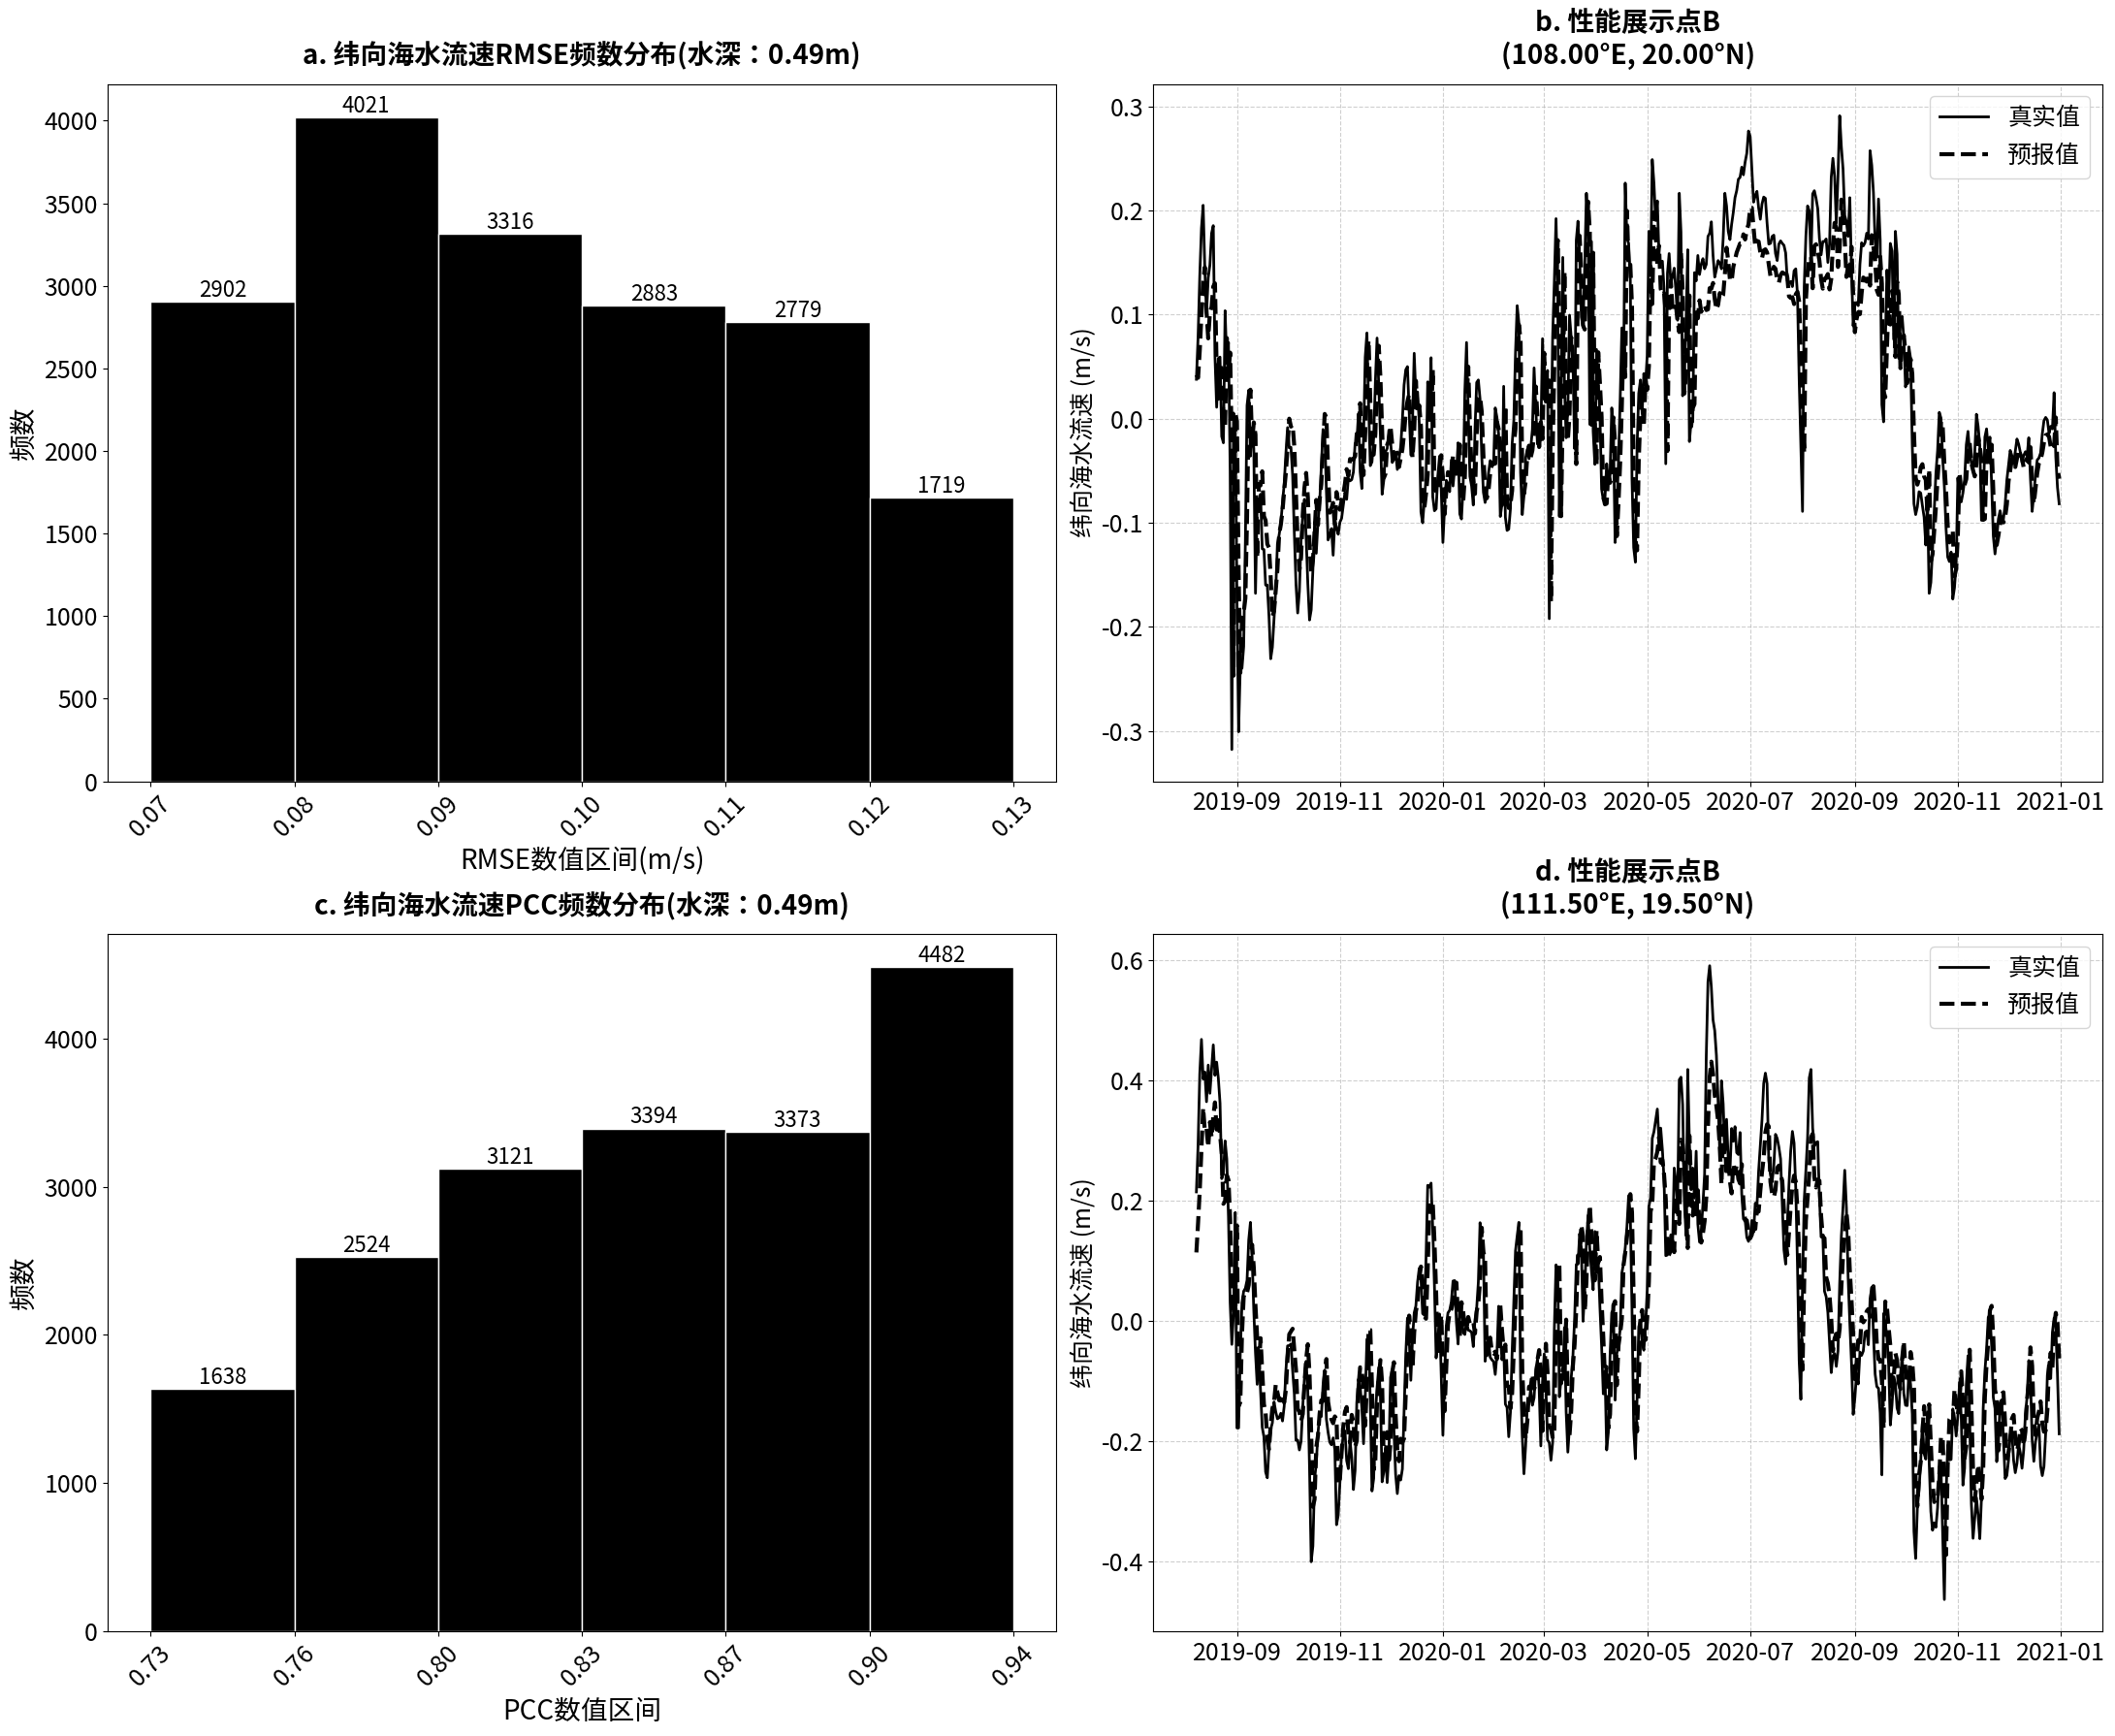

17 0
rmse_min 0.036657885 0.9358699446466863
rmse_max 0.065861315 0.9233531142472448
pcc_min 0.86626804 0.9234528499476388
pcc_max 0.97399133 0.9255971675061088


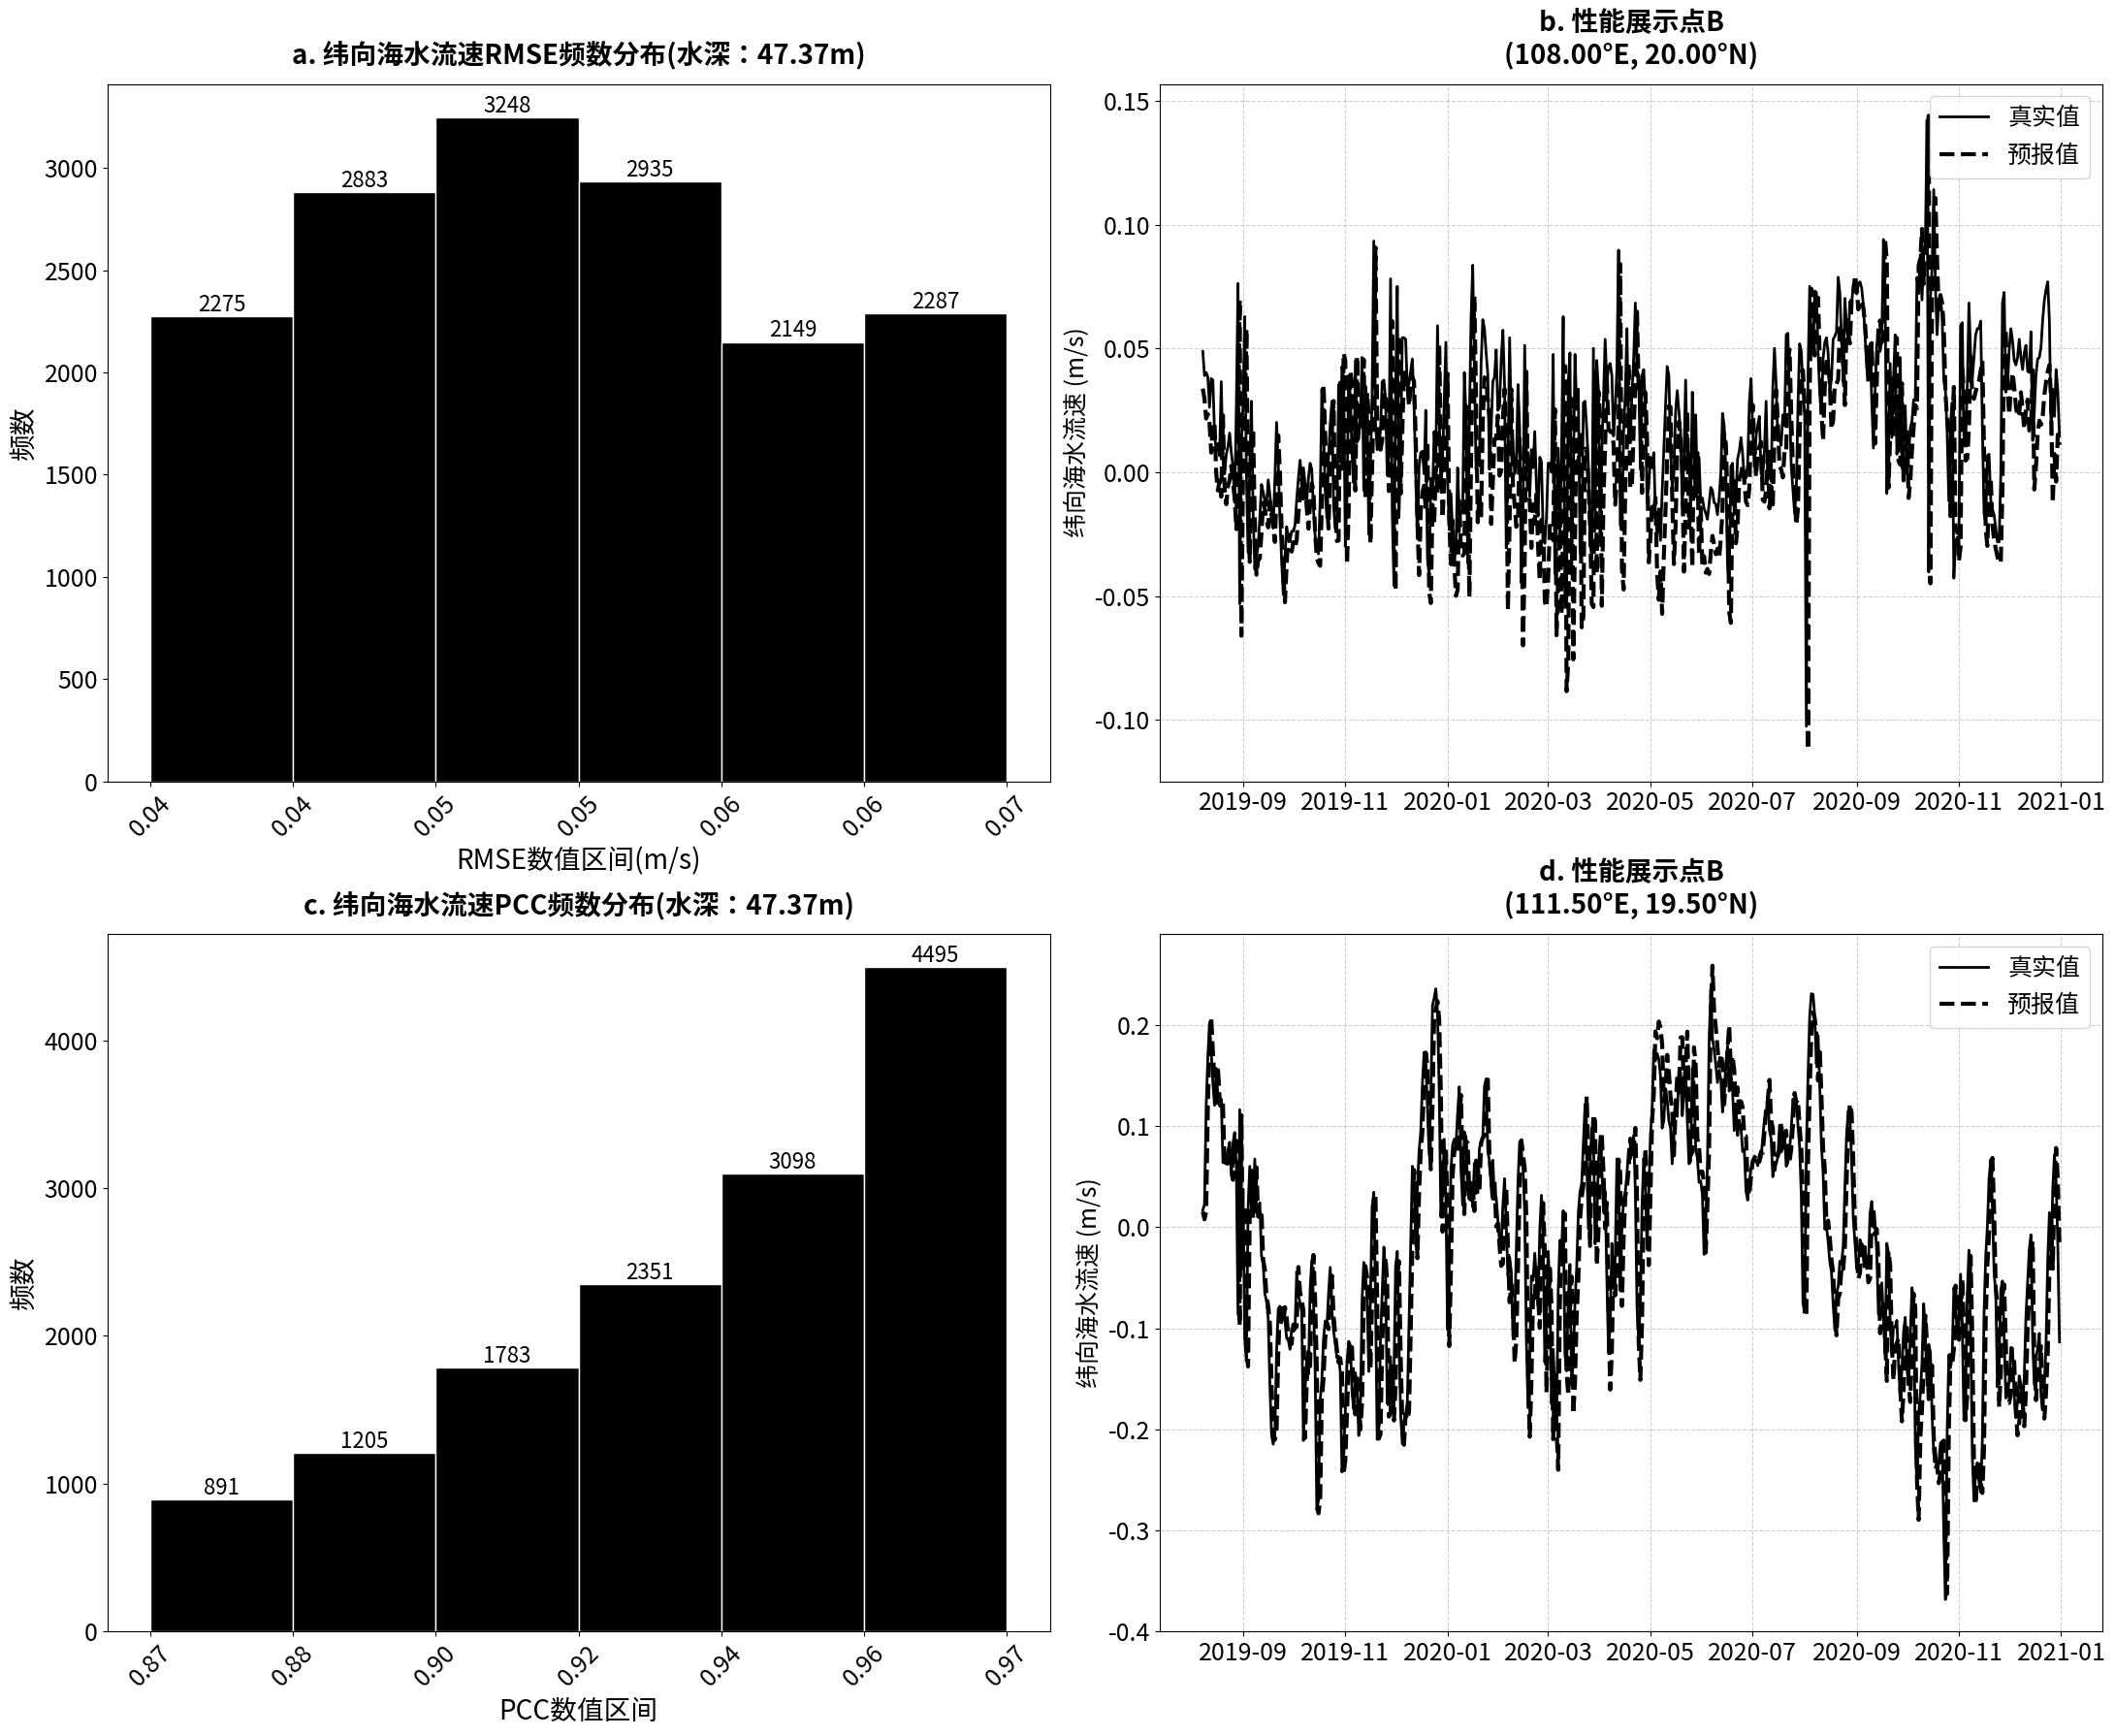

0 1
rmse_min 0.05802452 0.9489803921568627
rmse_max 0.11076081 0.905921568627451
pcc_min 0.66816586 0.9192941176470588
pcc_max 0.9332105 0.9123137254901961


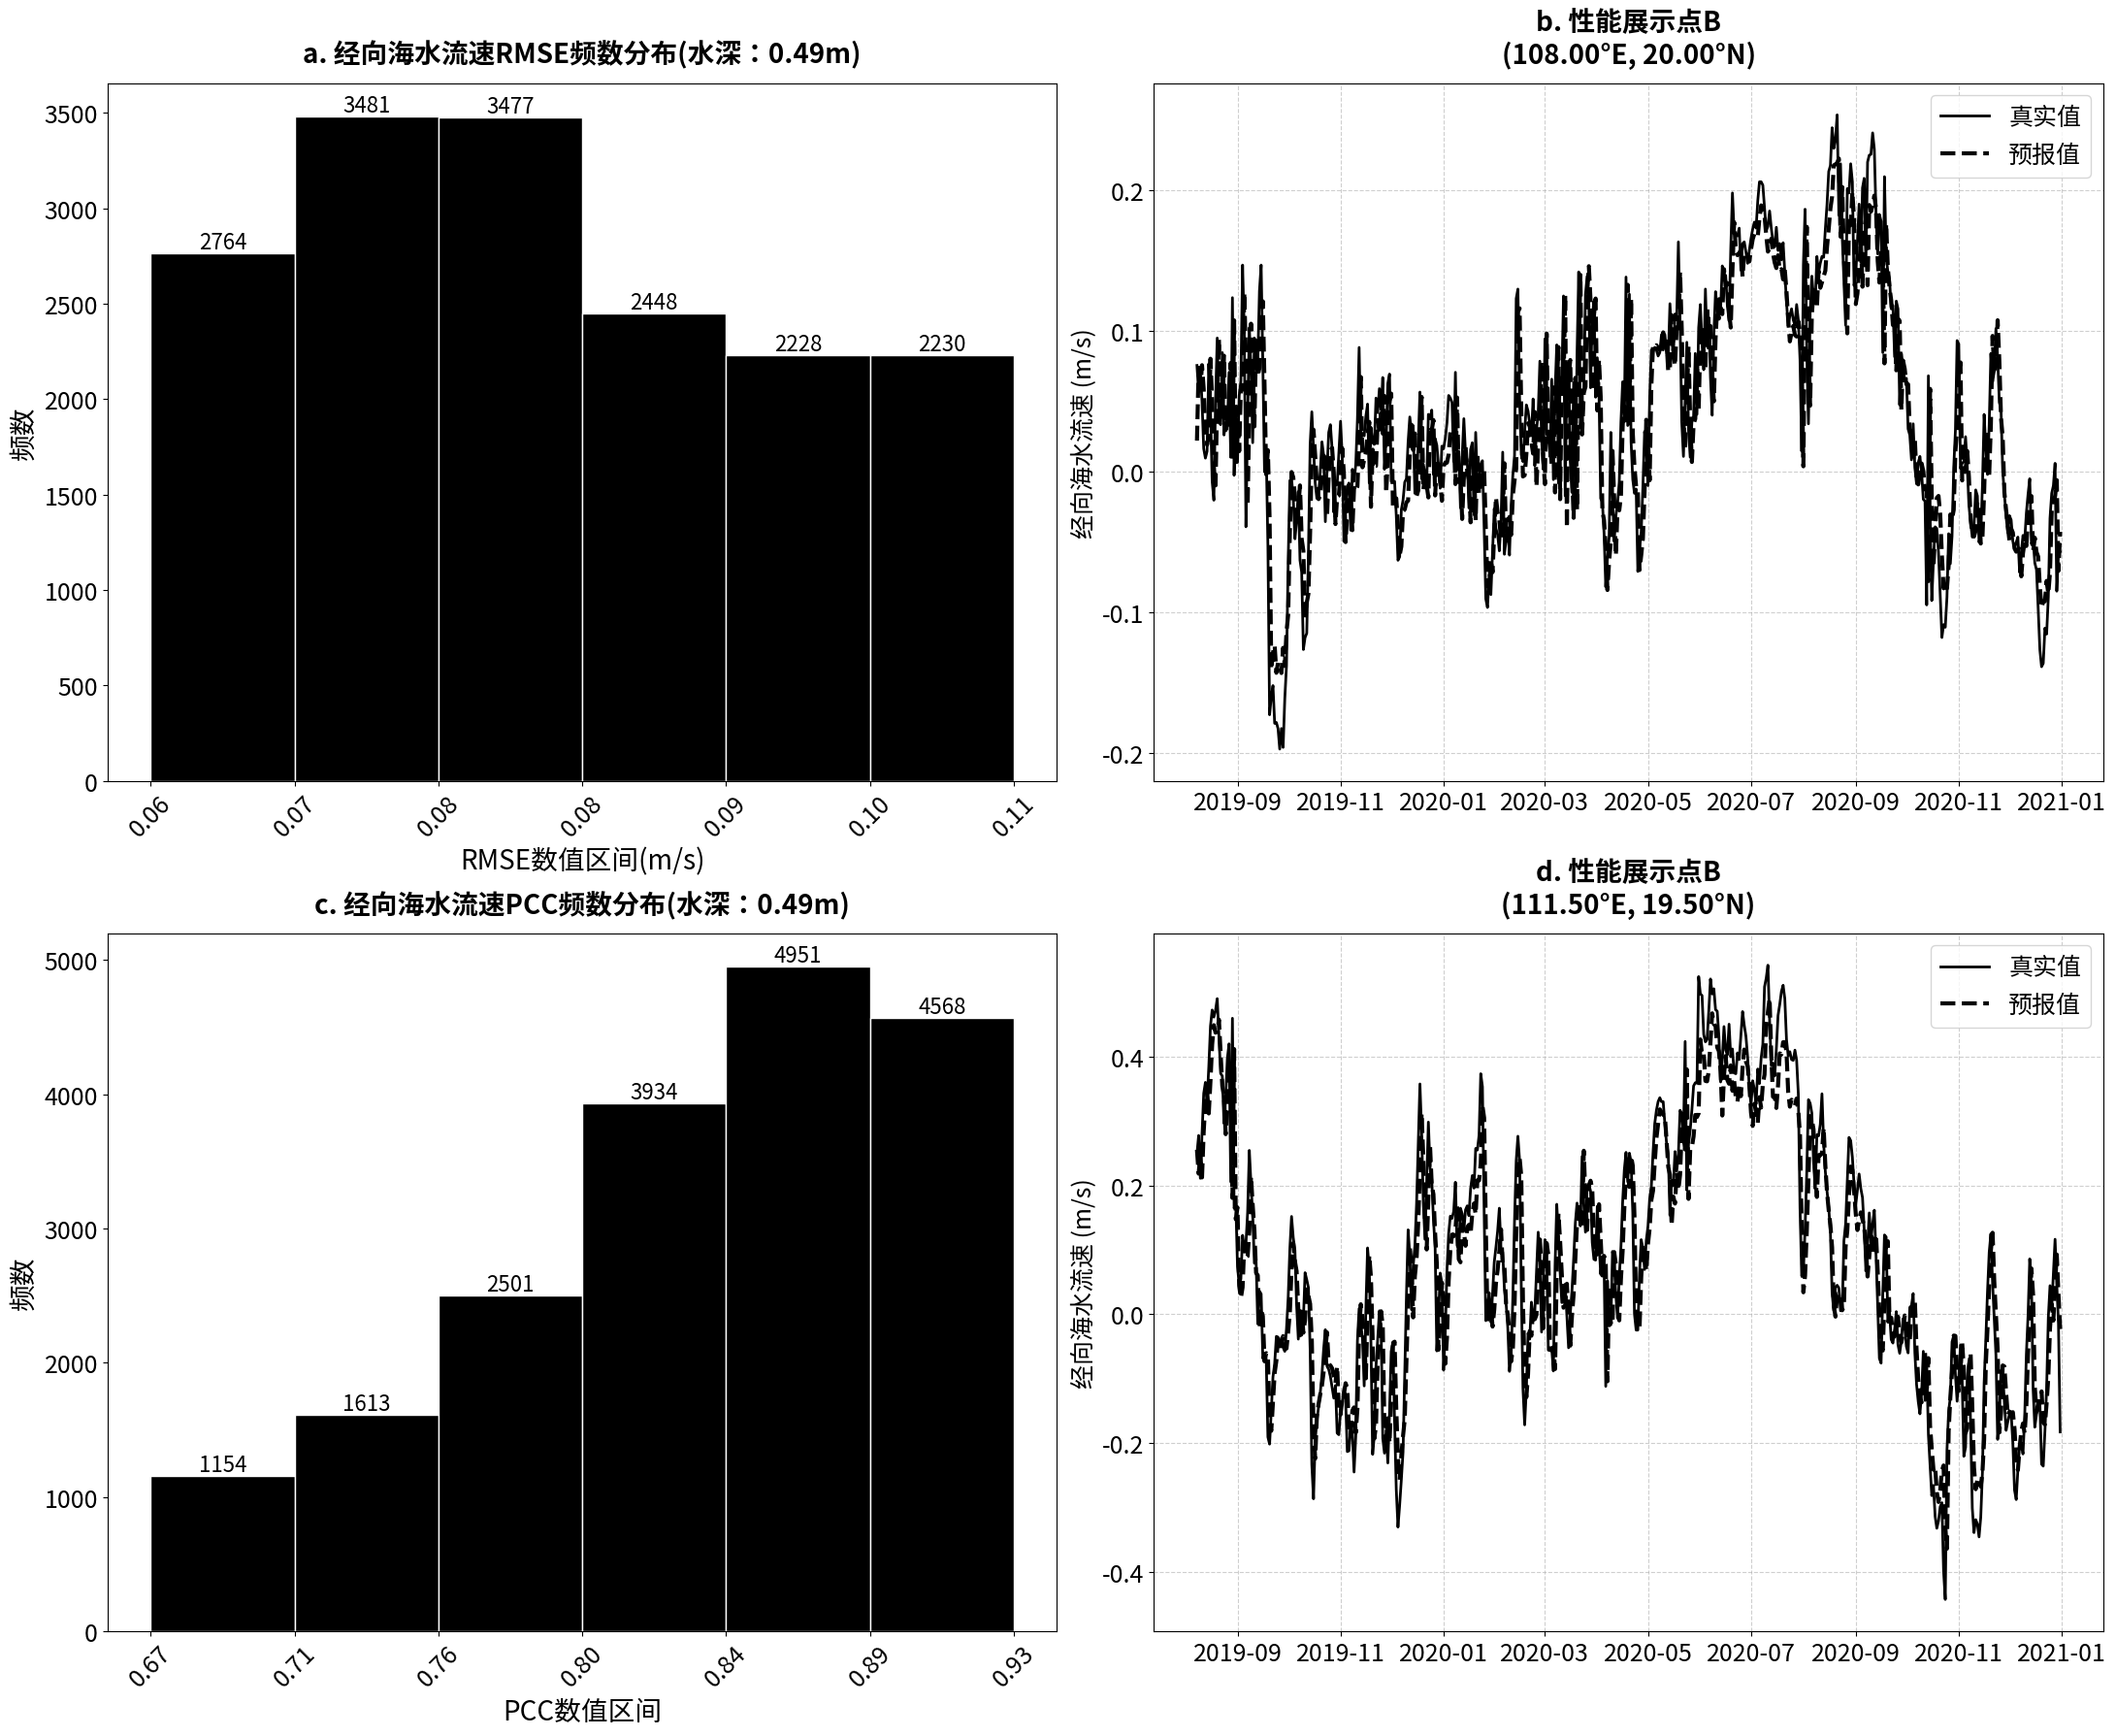

17 1
rmse_min 0.034374896 0.9441978756295816
rmse_max 0.06486673 0.9009624495088017
pcc_min 0.77645737 0.927492145813594
pcc_max 0.97265255 0.9229541714456689


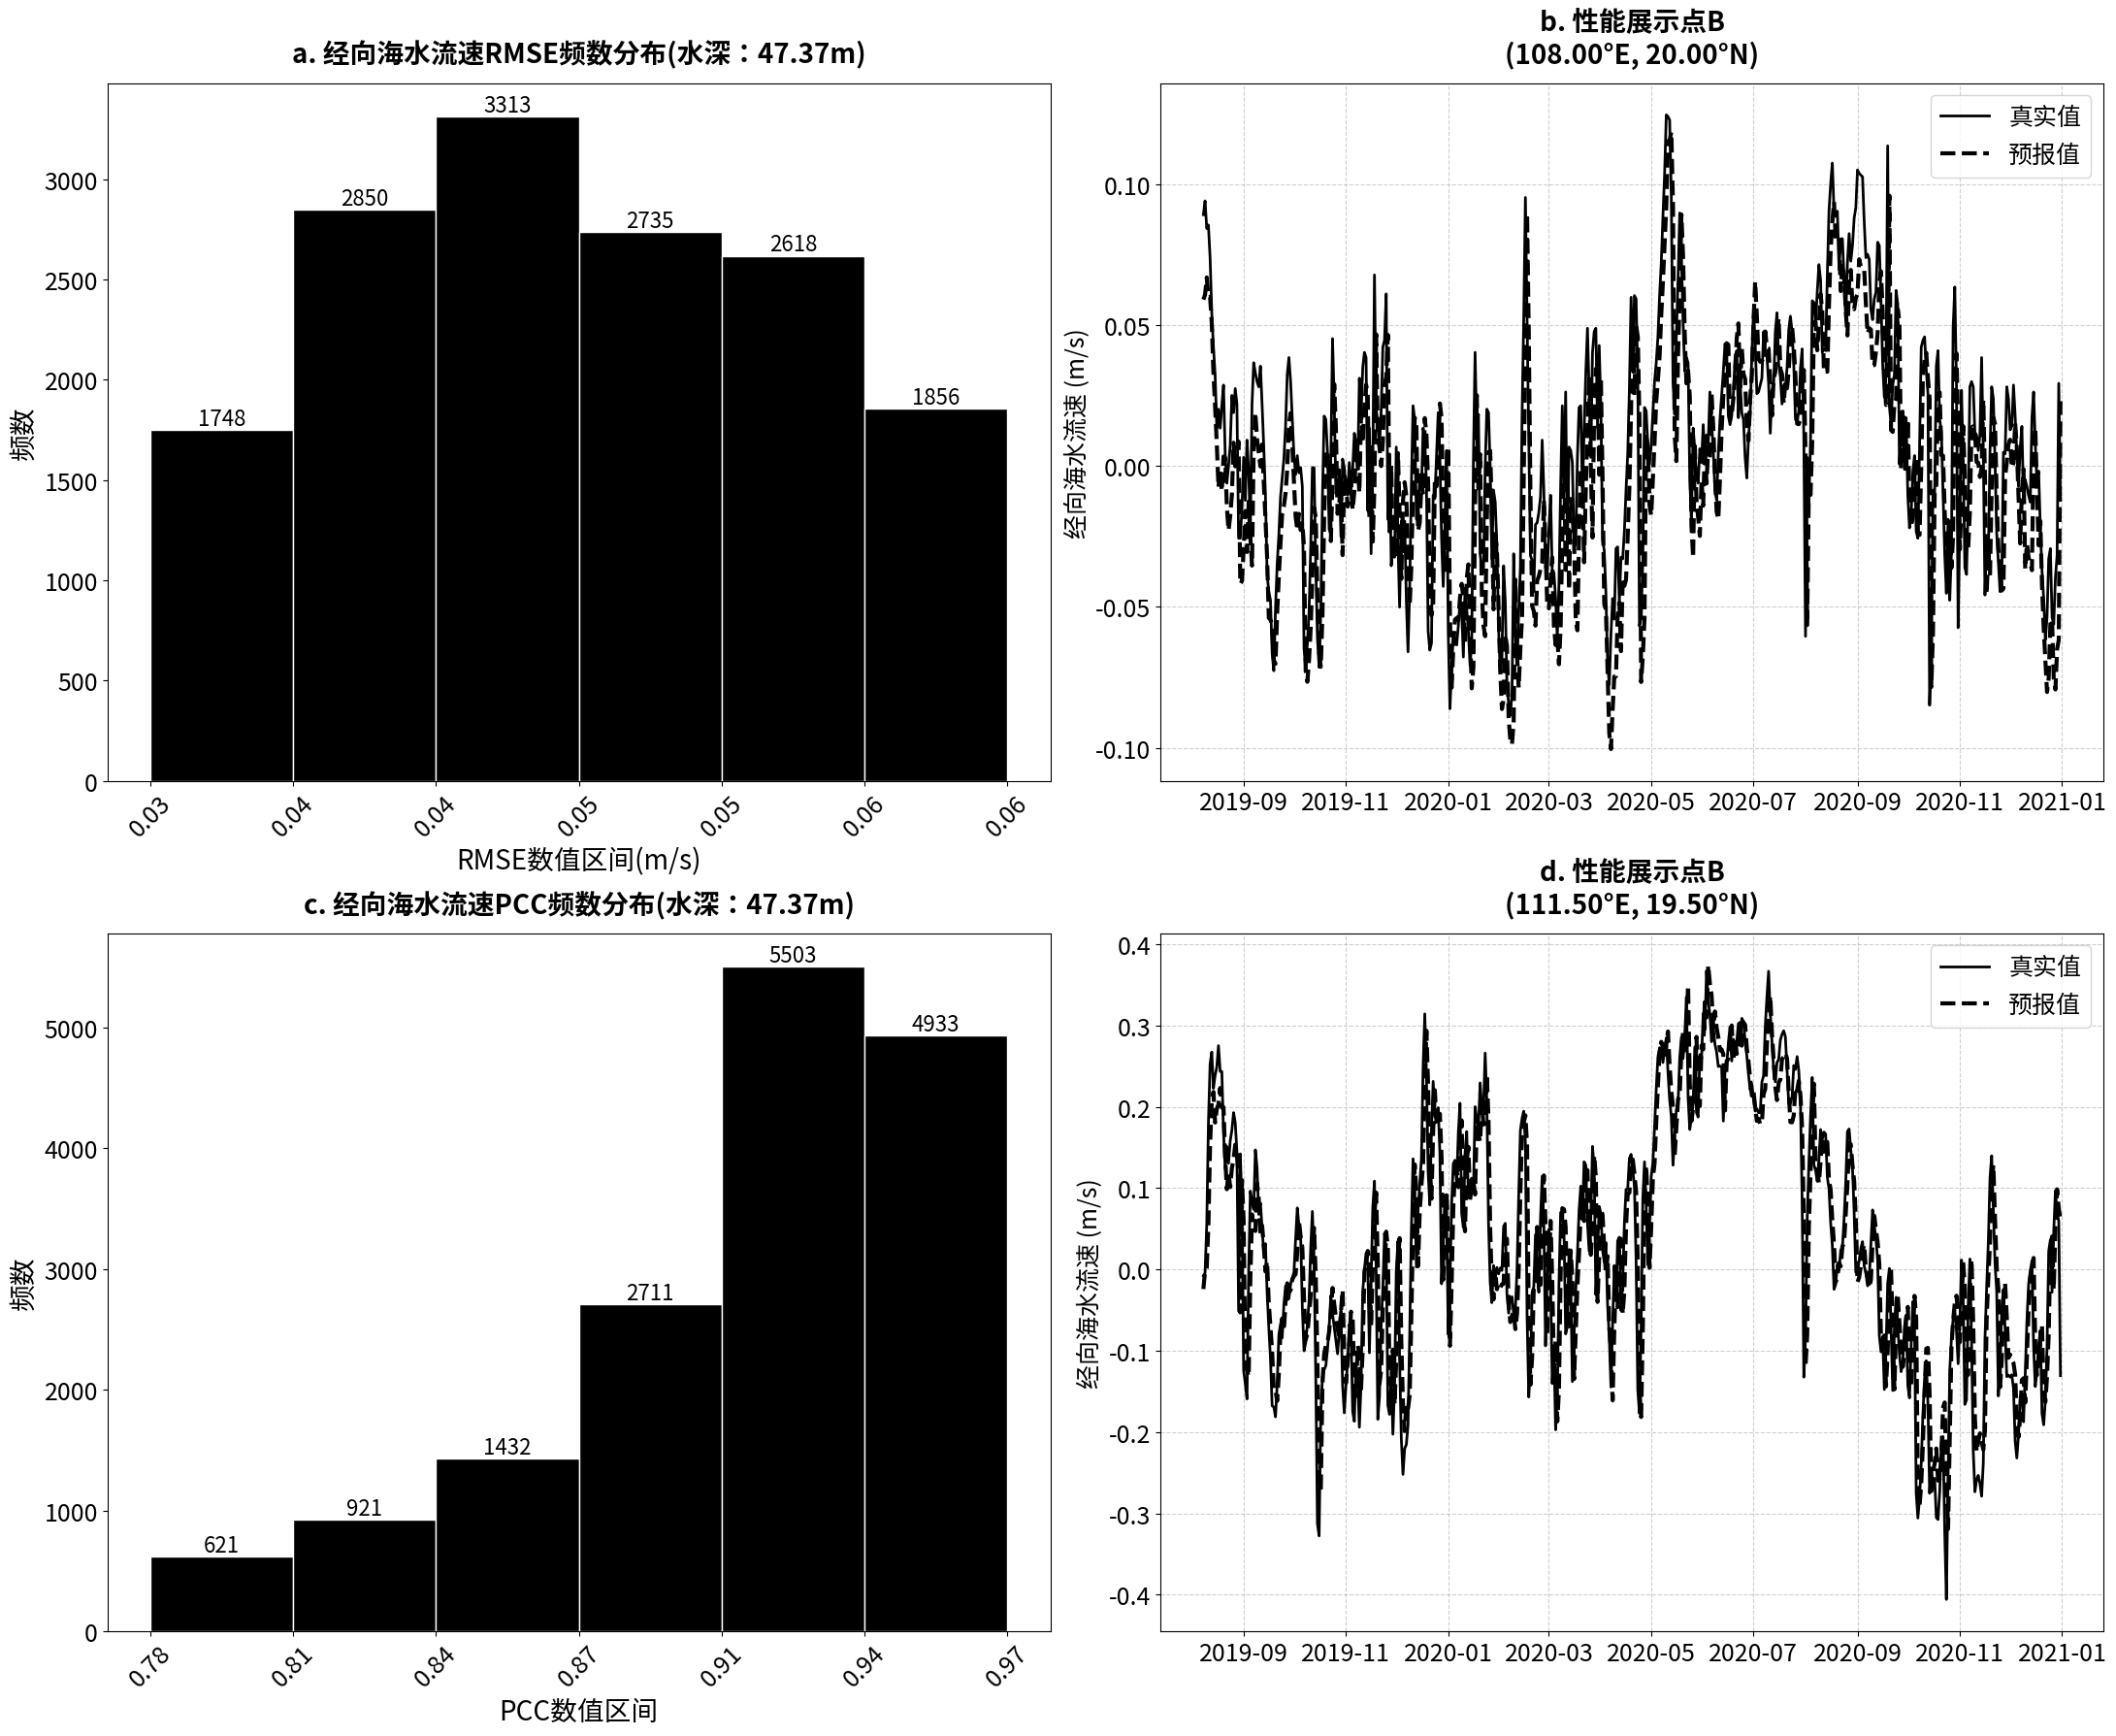

0 2
rmse_min 0.15506727 0.9264705882352942
rmse_max 0.3009605 0.9490196078431372
pcc_min 0.98444915 0.9272941176470588
pcc_max 0.9970324 0.9046274509803922


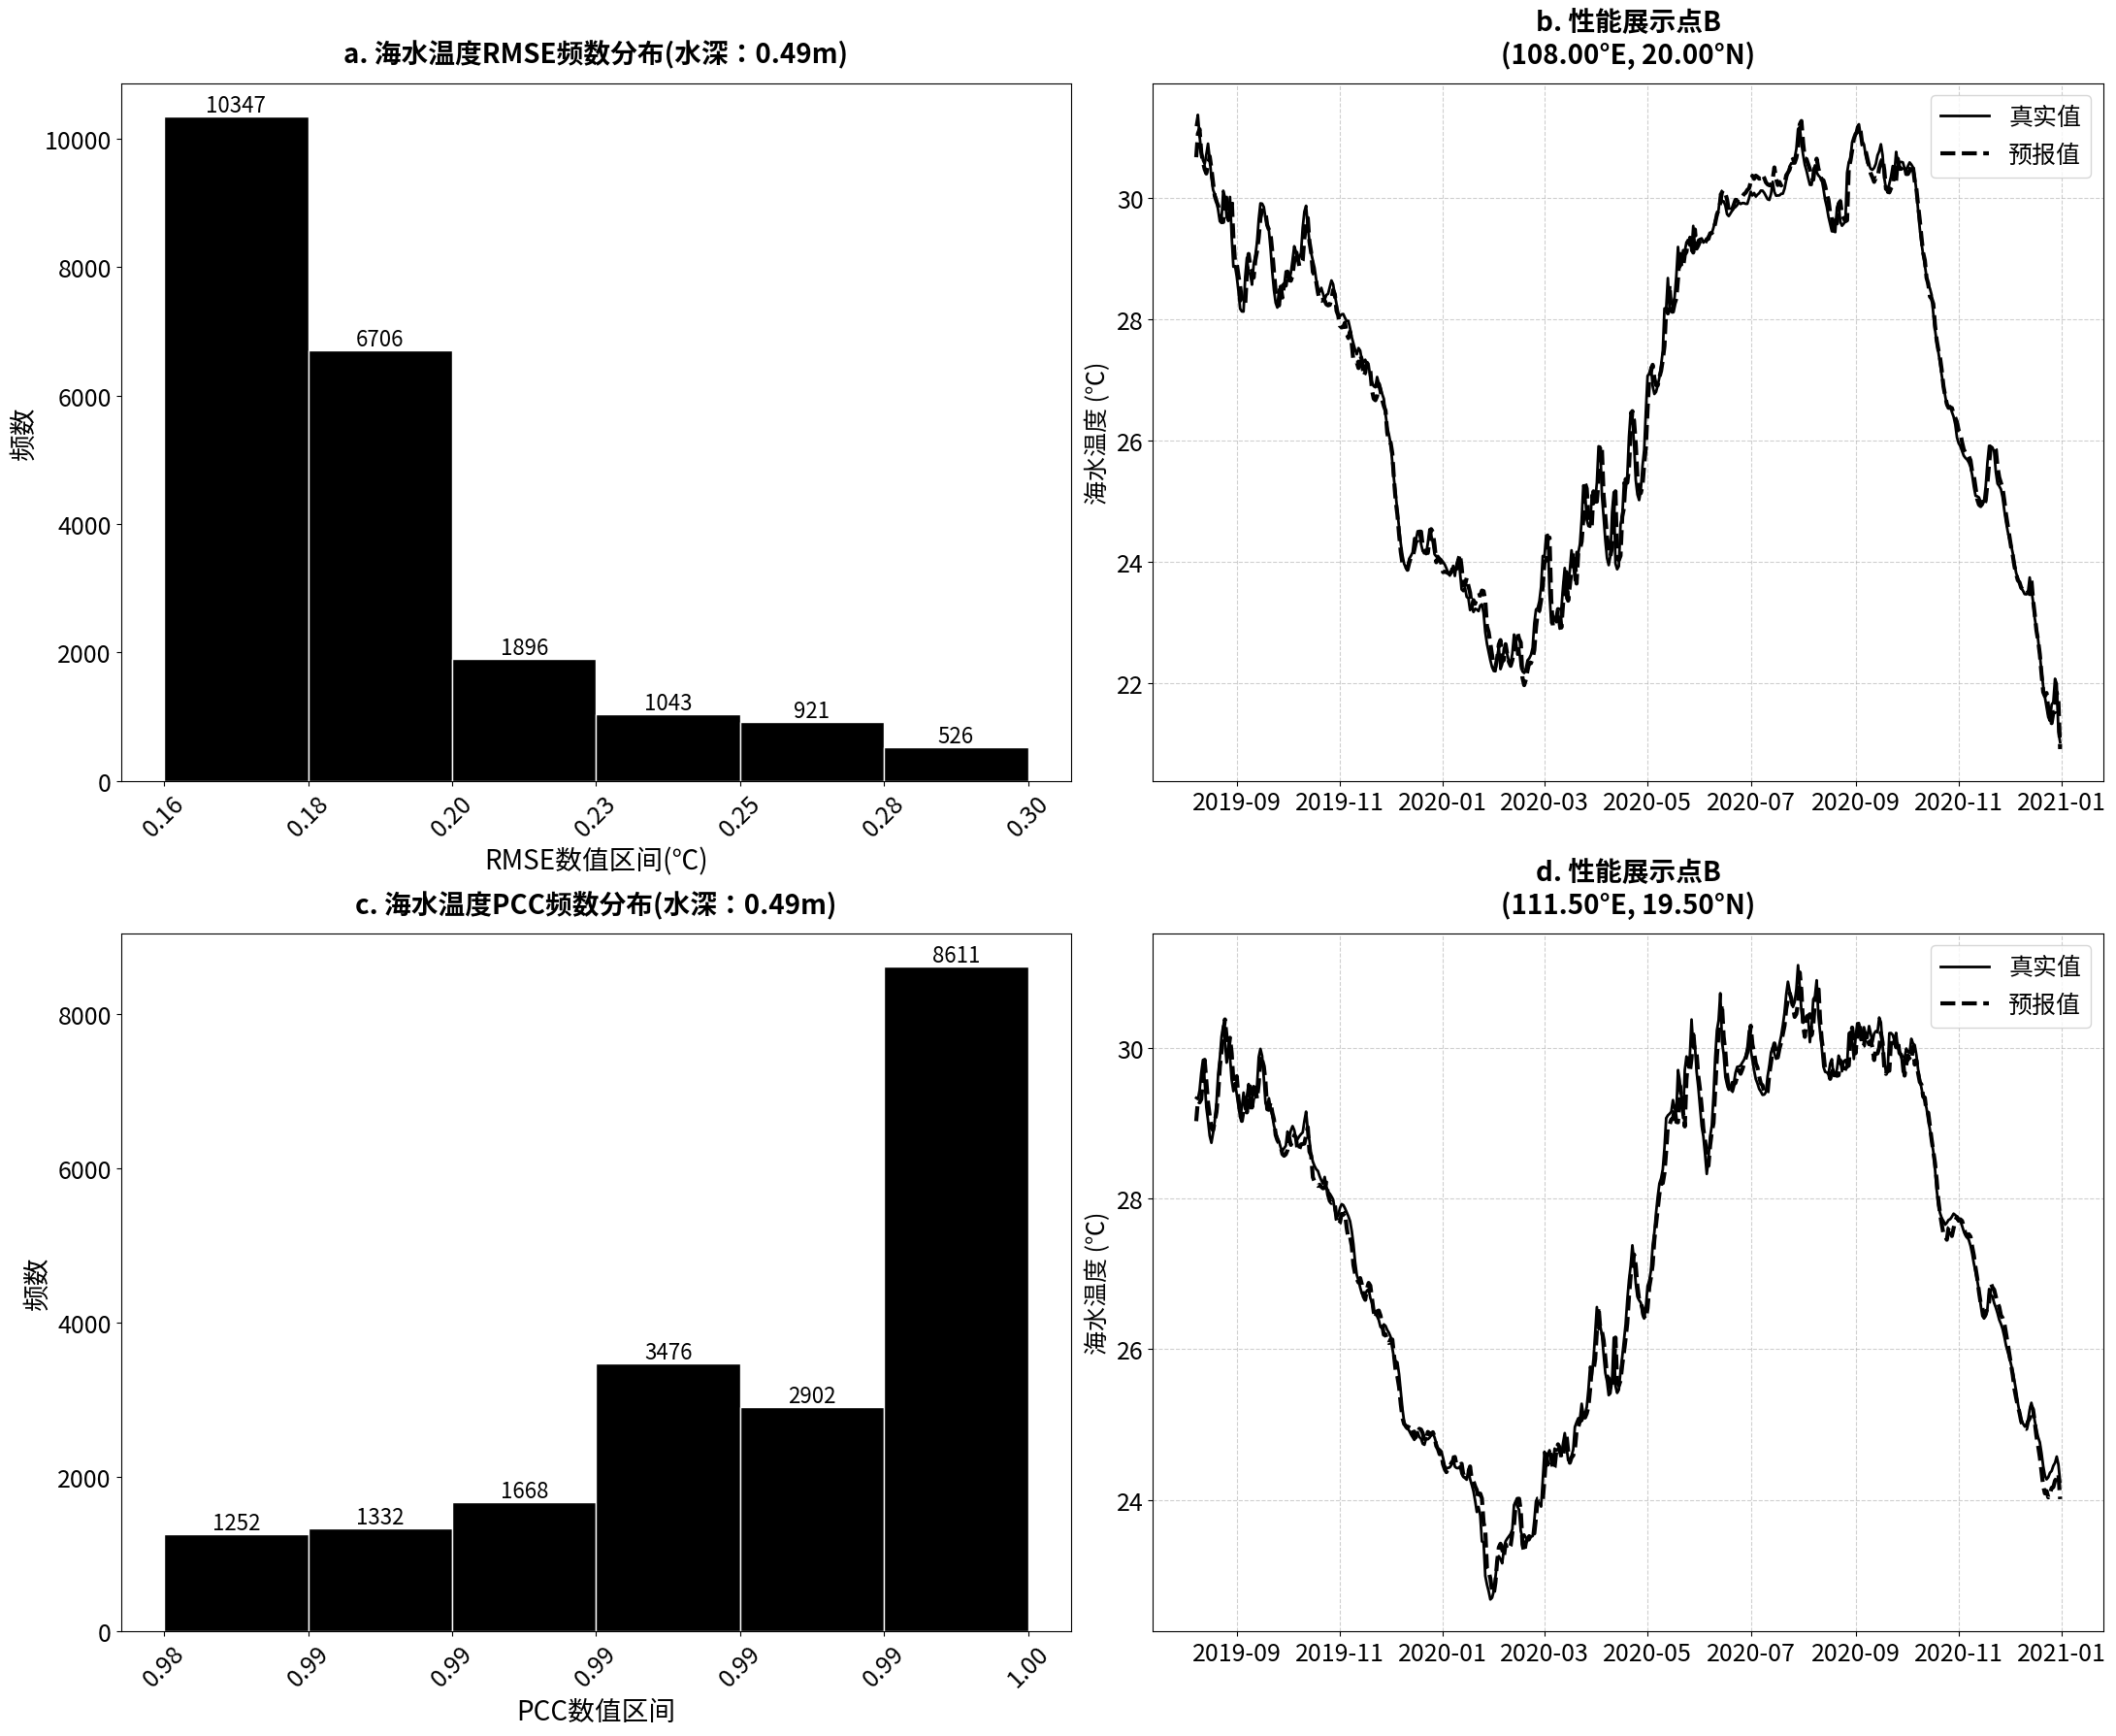

17 2
rmse_min 0.18592314 0.9184273470201315
rmse_max 0.32242978 0.9435917879210683
pcc_min 0.97166675 0.9236097269284433
pcc_max 0.9939774 0.9246561690253139


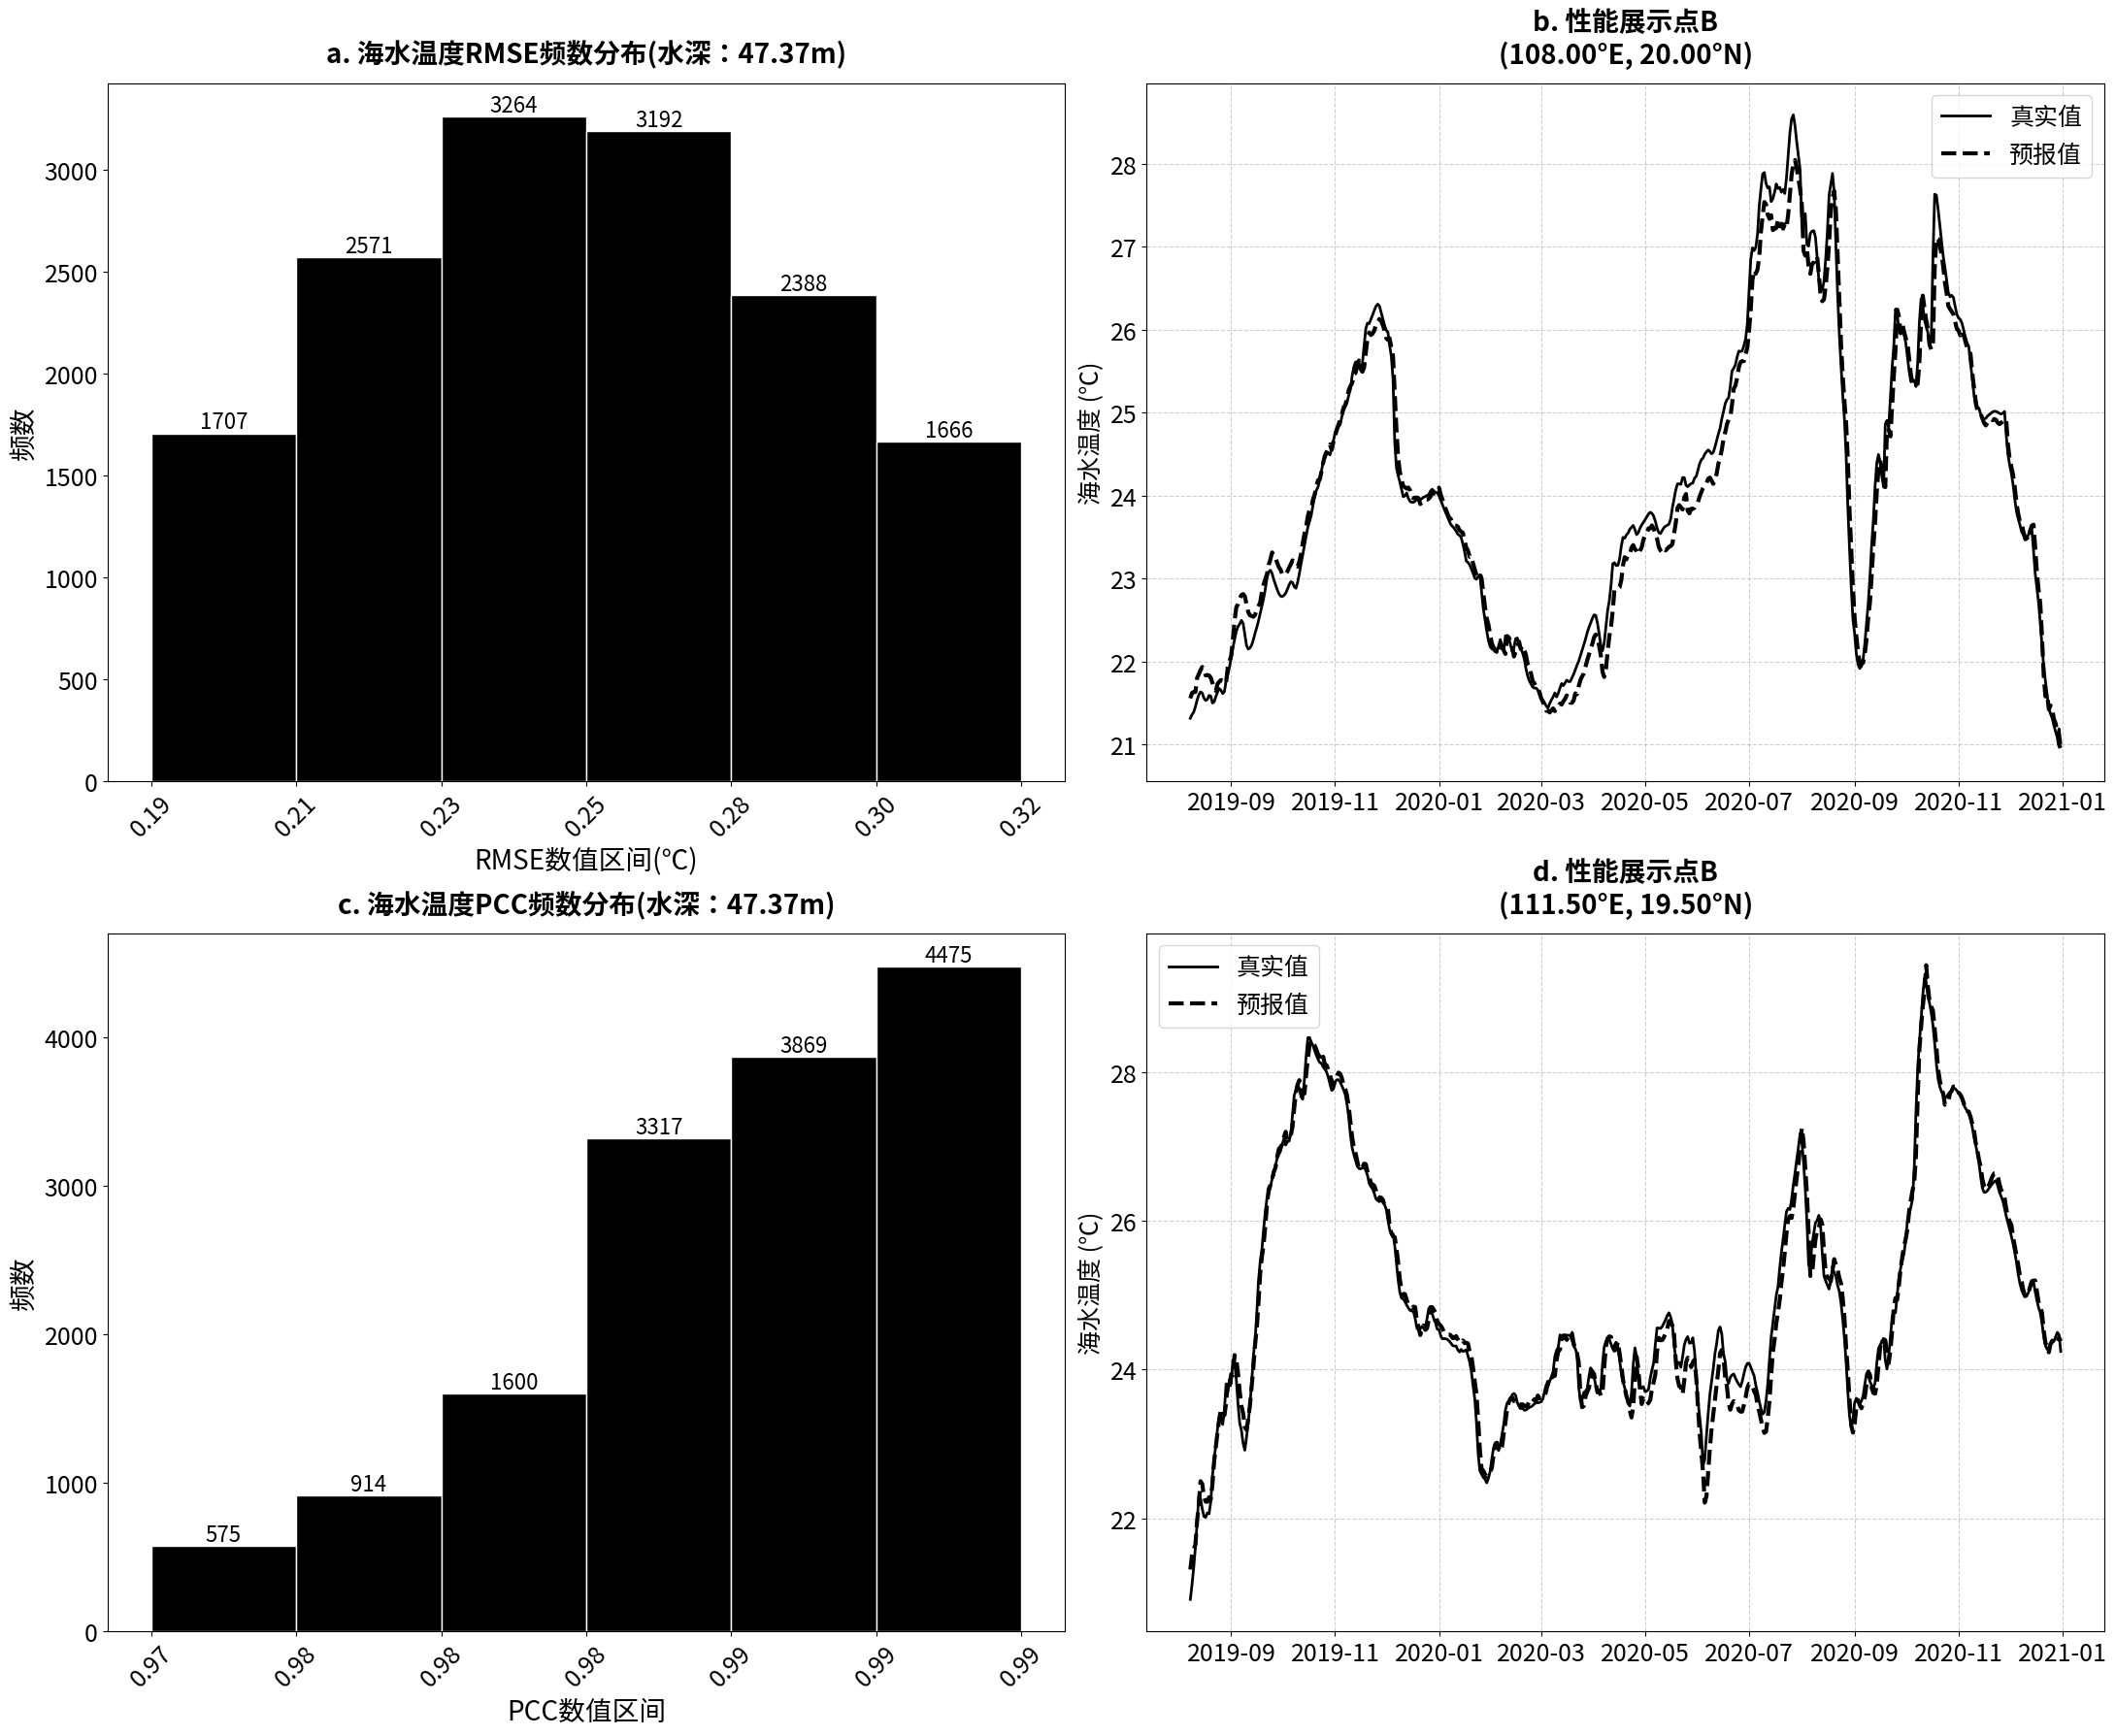

0 3
rmse_min 0.07478592 0.9182745098039216
rmse_max 0.167251 0.9050196078431373
pcc_min 0.963505 0.9225882352941176
pcc_max 0.9898622 0.9325882352941176


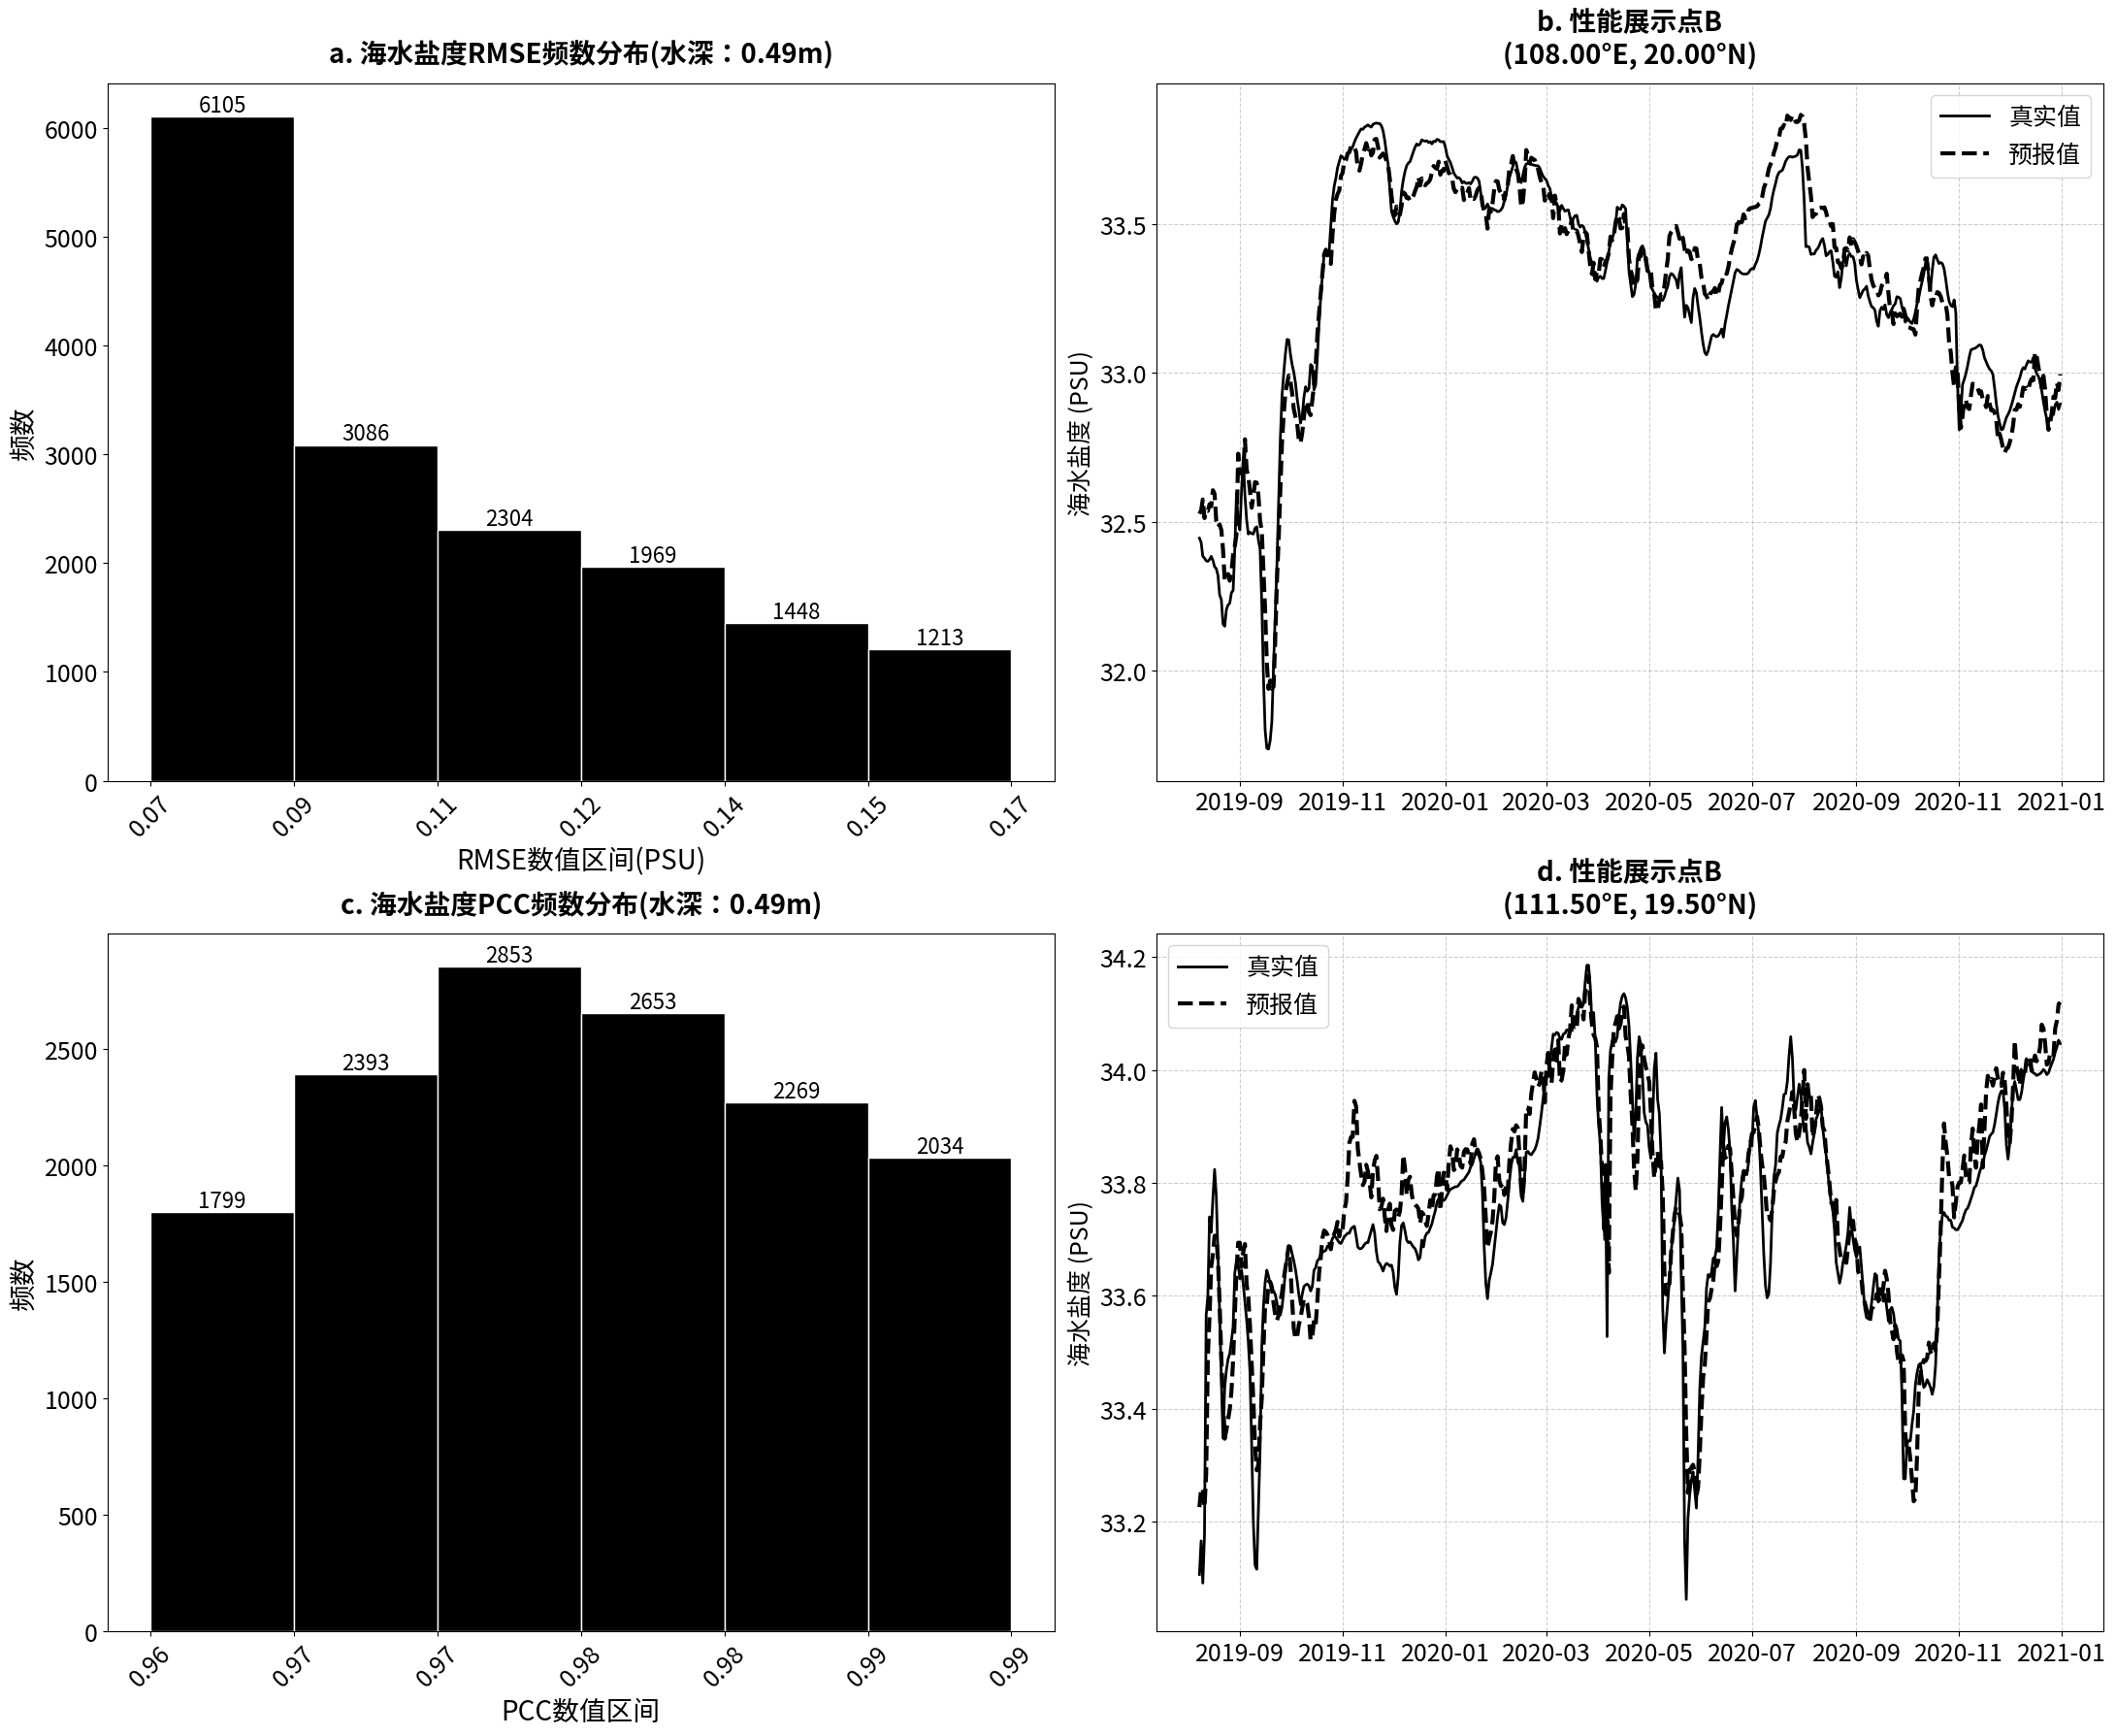

17 3
rmse_min 0.065904826 0.9026808849910305
rmse_max 0.07843733 0.924556507873231
pcc_min 0.96349454 0.9423460235200319
pcc_max 0.98849 0.923460235200319


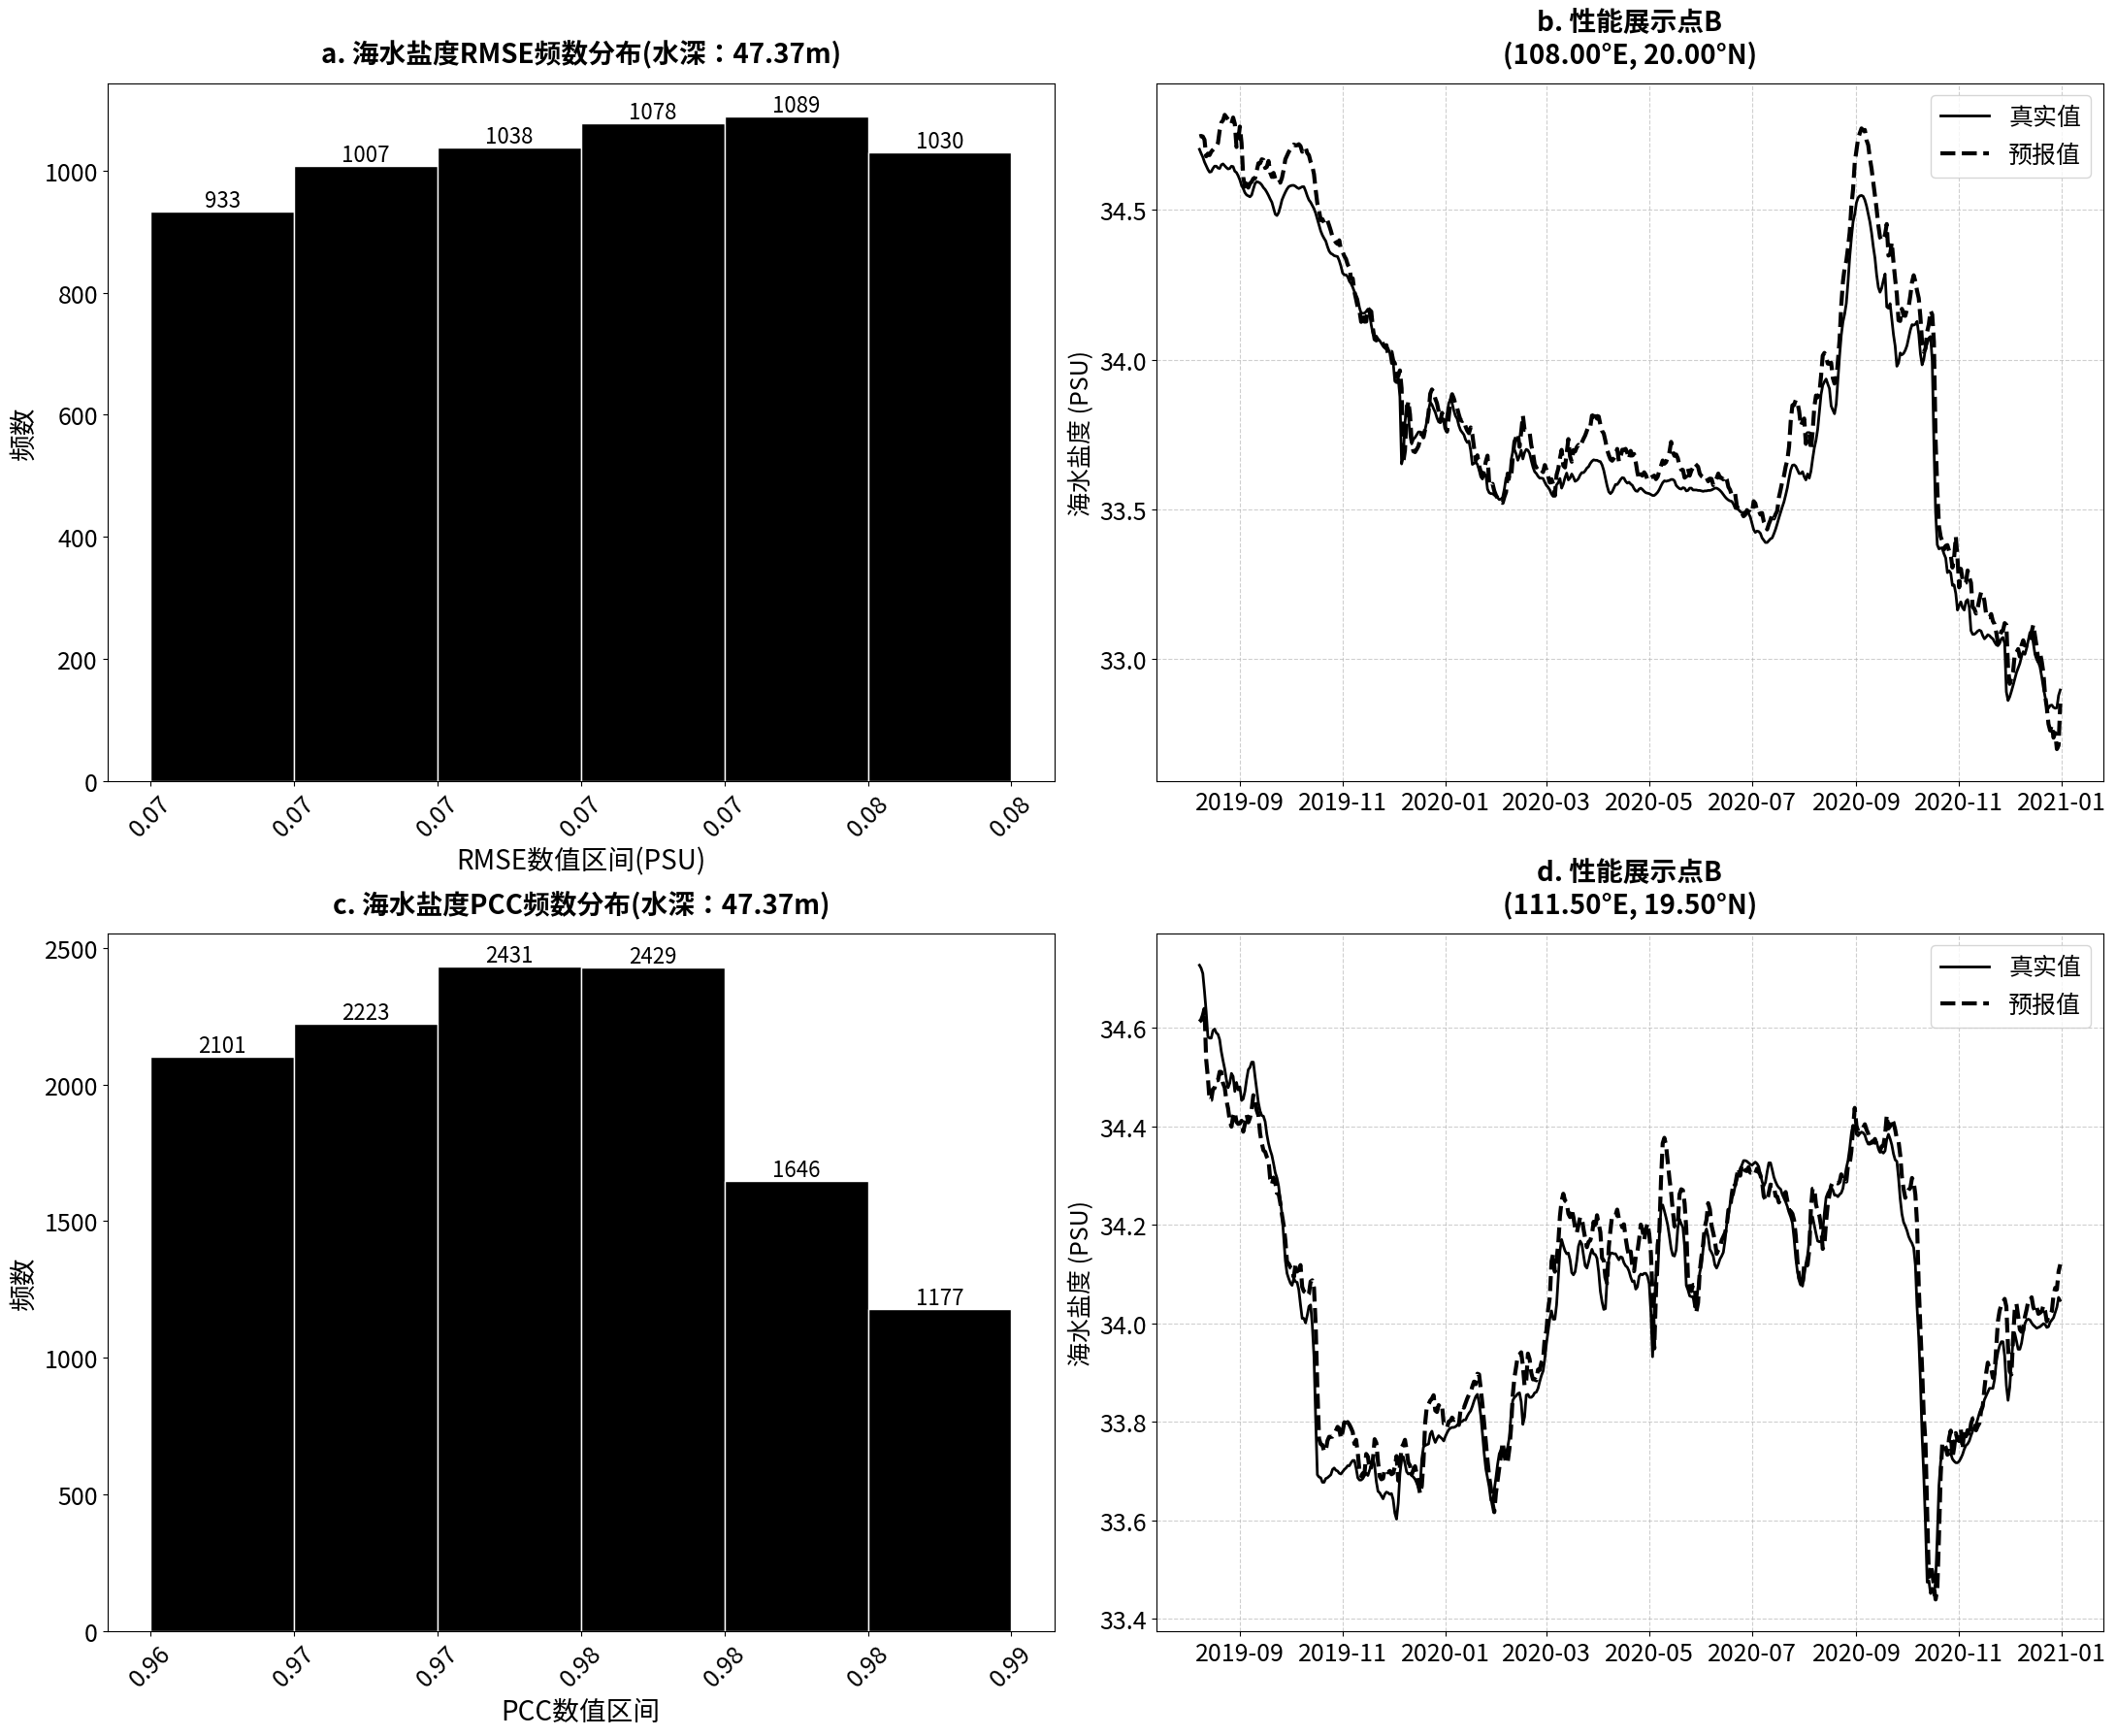

In [19]:
variable_s_lst = ['u', 'u', 'v', 'v', 't', 't', 's', 's', ]
depth_s_lst = [0, 50, 0, 50, 0, 50, 0, 50, ]

# variable_s_lst = ['u', 'u', 'v', 'v', ]
# depth_s_lst = [0, 50, 0, 50, ]

# variable_s_lst = ['u']
# depth_s_lst = [0]

for i in range(len(variable_s_lst)):
    variable_s = variable_s_lst[i]
    depth_s = depth_s_lst[i]

    idx_depth = np.argmin(np.abs(depth - depth_s))
    idx_variable = variable_lst.index(variable_s)

    mask_temp = mask_all[idx_depth, idx_variable, :]

    depth_str = str(round(depth[idx_depth], 2))
    print(idx_depth, idx_variable)

    lon_axis_temp = lon
    lat_axis_temp = lat
    time_axis_temp = time_axis.astype('int64') / 10**9
    time_str_temp = pd.to_datetime(time_axis).strftime('%Y-%m-%d %H:%M:%S')

    # 设置支持摄氏度符号的字体
    plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Arial Unicode MS', 'SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    fontsize = 20

    # 指定经纬度范围（示例范围，请根据您的数据调整）
    lon_min, lon_max = lon.min(), lon.max()  # 经度范围
    lat_min, lat_max = lat.min(), lat.max()    # 纬度范围

    for t in range(0, time_axis_temp.size, 7):
    # for t in range(0, 1, 14):
        #
        x_temp = x_merge[t, idx_depth, idx_variable, :]
        y_temp = y_merge[t, idx_depth, idx_variable, :]
        x_temp[mask_temp] = np.nan
        y_temp[mask_temp] = np.nan

        x_min = np.nanmin(x_temp)
        x_max = np.nanmax(x_temp)
        y_min = np.nanmin(y_temp)
        y_max = np.nanmax(y_temp)

        vmin, vmax = np.min([x_min, y_min]), np.max([x_max, y_max])

        # 创建图形和子图
        fig = plt.figure(figsize=(22, 10), facecolor='white')
        # 主网格
        gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 0.05])

        # ================================== 1.1 =====================================
        ax1 = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())

        # 设置地图范围
        ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

        # 绘制数据
        cf1 = ax1.pcolormesh(lon, lat, y_temp, cmap='jet', transform=ccrs.PlateCarree(),
                            vmin=vmin, vmax=vmax)

        # 添加地理特征
        ax1.add_feature(cfeature.LAND, facecolor='lightgray', alpha=1, zorder=1)
        ax1.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=1.2, alpha=1, zorder=2)

        # 设置标题和标签
        ax1.set_title(
            'Real(' + title_lst[idx_variable] + ' - ' + depth_str + 'm)' + '\n' + time_str_temp[t],
            fontsize=fontsize, pad=15, fontweight='bold'
        )
        ax1.set_xlabel('Longitude', fontsize=fontsize + 2)
        ax1.set_ylabel('Latitude', fontsize=fontsize + 2)

        # 设置经纬度刻度和格式（使用显示范围，而不是数据范围）
        display_lon_min, display_lon_max = ax1.get_xlim()  # 获取实际显示范围
        display_lat_min, display_lat_max = ax1.get_ylim()

        lon_step = max(1, round((display_lon_max - display_lon_min)/4))  # 4个主刻度
        lat_step = max(1, round((display_lat_max - display_lat_min)/4))

        # 设置刻度
        ax1.set_xticks(np.arange(display_lon_min, display_lon_max, lon_step),
                      crs=ccrs.PlateCarree())
        ax1.set_yticks(np.arange(display_lat_min, display_lat_max, lat_step),
                      crs=ccrs.PlateCarree())

        # 使用经纬度格式化器
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        ax1.xaxis.set_major_formatter(lon_formatter)
        ax1.yaxis.set_major_formatter(lat_formatter)

        # 调整刻度标签大小
        ax1.tick_params(labelsize=fontsize)

        # 添加网格线
        ax1.gridlines(draw_labels=False, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

        # # 添加colorbar
        # cbar = plt.colorbar(cf, ax=ax1, pad=0.02, aspect=30, shrink=0.85)
        # cbar.set_label(unit_lst[idx_variable], fontsize=fontsize)
        # cbar.ax.tick_params(labelsize=fontsize-2)

        # ================================== 1.2 =====================================
        ax2 = fig.add_subplot(gs[1], projection=ccrs.PlateCarree())

        # 设置地图范围
        ax2.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

        # 绘制数据
        cf2 = ax2.pcolormesh(lon, lat, x_temp, cmap='jet', transform=ccrs.PlateCarree(),
                            vmin=vmin, vmax=vmax)

        # 添加地理特征
        ax2.add_feature(cfeature.LAND, facecolor='lightgray', alpha=1, zorder=1)
        ax2.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=1.2, alpha=1, zorder=2)

        # 设置标题和标签
        ax2.set_title(
            'Prediction(' + title_lst[idx_variable] + ' - ' + depth_str + 'm)' + '\n' + time_str_temp[t],
            fontsize=fontsize, pad=15, fontweight='bold'
        )
        ax2.set_xlabel('Longitude', fontsize=fontsize + 2)
        ax2.set_ylabel('Latitude', fontsize=fontsize + 2)

        # 设置经纬度刻度和格式（使用显示范围，而不是数据范围）
        display_lon_min, display_lon_max = ax2.get_xlim()  # 获取实际显示范围
        display_lat_min, display_lat_max = ax2.get_ylim()

        lon_step = max(1, round((display_lon_max - display_lon_min)/4))  # 4个主刻度
        lat_step = max(1, round((display_lat_max - display_lat_min)/4))

        # 设置刻度
        ax2.set_xticks(np.arange(display_lon_min, display_lon_max, lon_step),
                      crs=ccrs.PlateCarree())
        ax2.set_yticks(np.arange(display_lat_min, display_lat_max, lat_step),
                      crs=ccrs.PlateCarree())

        # 使用经纬度格式化器
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        ax2.xaxis.set_major_formatter(lon_formatter)
        ax2.yaxis.set_major_formatter(lat_formatter)

        # 调整刻度标签大小
        ax2.tick_params(labelsize=fontsize)

        # 添加网格线
        ax2.gridlines(draw_labels=False, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

        # ============================
        # 添加colorbar
        cax = fig.add_subplot(gs[2])
        cbar = plt.colorbar(cf2, cax=cax, pad=0.02, aspect=30)
        cbar.set_label(unit_lst[idx_variable], fontsize=fontsize)
        cbar.ax.tick_params(labelsize=fontsize-2)
        cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

        # 调整布局
        plt.tight_layout()
        filename_save = time_str_temp[t] + '_' + variable_s + '-' + 'depth' + depth_str + 'm.png'
        dir_save_final = os.path.join('../data', 'data_draw', dir_sub, title_lst[idx_variable], depth_str)
        if not os.path.exists(dir_save_final):
            os.makedirs(dir_save_final, exist_ok=False)
        filepath_save = os.path.join(dir_save_final, filename_save)
        plt.savefig(filepath_save, dpi=300)
        # plt.show()
        plt.close()